# Temat testów
### Czy istnieje istotna statystycznie różnica w poprawności odpowiedzi w zależności od cech osobowościowych z ankiety?

In [2]:
import pandas as pd

from functions.tests.independent_groups.two_groups import chi2_or_fisher_test, mann_whitney_test
from functions.tests.independent_groups.more_than_two_groups import chi2_or_chi2_yate_test, kruskal_wallis_test
from functions.tests.posthoc import posthocNemenyi_test
from functions.plots import plot_heatmap
from functions.others import choose_dominant_kind, change_to_ranges_podst, change_to_ranges_roz

In [3]:
df_answers = pd.read_csv('/Users/martasolarz/Studies/Thesis/Master_thesis/prepare_datasets/sets/correctness.csv')

df_quest = pd.read_csv(
    '/Users/martasolarz/Studies/Thesis/data/survey.csv',
).fillna('NO_VAL')

df_quest = df_quest[df_quest.ID != 6]  # odrzucony uczestnik ze względu na metryki eye trackingowe

In [4]:
# zagregowane kolumny - podział na tych co pisali i nie pisali danej matury, rangowe przepisanie wyników matur oraz agregacja typów uczenia poznawczego (wybór dominującego):
df_quest['MAT'] = df_quest['MAT_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL')
df_quest['POL'] = df_quest['JP_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL')
df_quest['HIST'] = df_quest['HIST_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL')
df_quest['Typ_uczenia'] = df_quest.apply(choose_dominant_kind, axis=1)
df_quest['Kierunek_studiów'] = df_quest['Kierunek_studiów'].apply(lambda x: 'MISMaP Geografia' if x == 'Geografia, w ramach studiów międzyobszarowych' else x)
df_quest['JP_podst'] = df_quest['JP_podst'].apply(change_to_ranges_podst)
df_quest['MAT_podst'] = df_quest['MAT_podst'].apply(change_to_ranges_podst)
df_quest['JP_roz'] = df_quest['JP_roz'].apply(change_to_ranges_roz)
df_quest['MAT_roz'] = df_quest['MAT_roz'].apply(change_to_ranges_roz)
df_quest['HIST_roz'] = df_quest['HIST_roz'].apply(change_to_ranges_roz)
df_quest['FIZ_roz'] = df_quest['FIZ_roz'].apply(change_to_ranges_roz)

df_quest.head()

,ID,Płeć,Rok_urodzenia,Kierunek_studiów,Rok_studiów,Specjalność,Wady_wzroku,Daltonizm,Ilość_snu,JP_podst,...,Rank_map,Rank_txt,Rank_plt,Rank_tab,Data,Godzina,MAT,POL,HIST,Typ_uczenia
0,1,M,2002,MISMaP Geografia,2,SPOŁ-EKO,0,1,6,4,...,3,4,1,2,2023-05-24,11:44:20,VAL,VAL,NO_VAL,Kinestetyk
1,2,M,2003,Gospodarka przestrzenna,1,NO_VAL,1,1,<6,2,...,2,3,1,4,2023-05-24,12:21:03,VAL,VAL,NO_VAL,Brak dominującego
2,3,M,2001,Geografia,3,GEOINF,0,1,8,2,...,1,4,3,2,2023-05-24,12:41:09,VAL,NO_VAL,NO_VAL,Wzrokowiec
3,4,K,2000,Geografia,3,GEOINF,0,1,8,2,...,2,4,3,1,2023-05-24,13:15:20,NO_VAL,VAL,NO_VAL,Brak dominującego
4,5,K,2002,Geografia,3,GEOINF,0,1,7,2,...,2,4,1,3,2023-05-24,13:35:17,NO_VAL,NO_VAL,NO_VAL,Wzrokowiec


In [5]:
df_merge = df_answers.merge(df_quest, on='ID').set_index('ID')
df_merge.tail()

,1a_trud,1b_trud,2a_trud,2b_trud,3a_trud,3b_trud,Trud_all,Corr_all,1a_corr,1b_corr,...,Rank_map,Rank_txt,Rank_plt,Rank_tab,Data,Godzina,MAT,POL,HIST,Typ_uczenia
ID,,,,,,,,,,,,,,,,,,,,,
42,2,1,2,1,2,2,10,5,1,1,...,2,4,1,3,2023-06-07,11:42:55,NO_VAL,NO_VAL,NO_VAL,Wzrokowiec
43,1,2,2,2,3,3,13,5,1,1,...,2,3,1,2,2023-06-07,13:04:51,NO_VAL,NO_VAL,NO_VAL,Brak dominującego
44,1,1,3,1,2,3,11,3,1,1,...,2,1,2,1,2023-06-07,14:13:38,VAL,NO_VAL,NO_VAL,Brak dominującego
45,2,1,2,2,2,2,11,3,1,1,...,2,4,3,1,2023-06-07,14:27:37,VAL,NO_VAL,NO_VAL,Słuchowiec
46,1,3,2,2,2,3,13,4,0,1,...,1,3,3,3,2023-06-07,15:19:52,NO_VAL,NO_VAL,NO_VAL,Brak dominującego


Przygotowanie data setów dla wszystkich testowanych przypadków:

Poprawność vs dane osobowe

In [6]:
# zsumowany wynik wszystkie grafiki
df_wynik = df_merge.copy()
df_wynik.rename(columns={'Corr_all': 'corr', 'Trud_all': 'diff'}, inplace=True)

# zsumowany wynik - grafiki A
df_sumA = df_merge.copy()
df_sumA.rename(columns={'SumCorr_a': 'corr', 'SumTrud_a': 'diff'}, inplace=True)

# zsumowany wynik - grafiki B
df_sumB = df_merge.copy()
df_sumB.rename(columns={'SumCorr_b': 'corr', 'SumTrud_b': 'diff'}, inplace=True)

# zsumowany wynik - grafiki 1
df_sum1 = df_merge.copy()
df_sum1.rename(columns={'SumCorr_1': 'corr', 'SumTrud_1': 'diff'}, inplace=True)

# zsumowany wynik - grafiki 2
df_sum2 = df_merge.copy()
df_sum2.rename(columns={'SumCorr_2': 'corr', 'SumTrud_2': 'diff'}, inplace=True)

# zsumowany wynik - grafiki 3
df_sum3 = df_merge.copy()
df_sum3.rename(columns={'SumCorr_3': 'corr', 'SumTrud_3': 'diff'}, inplace=True)
df_sum3

,1a_trud,1b_trud,2a_trud,2b_trud,3a_trud,3b_trud,Trud_all,Corr_all,1a_corr,1b_corr,...,Rank_map,Rank_txt,Rank_plt,Rank_tab,Data,Godzina,MAT,POL,HIST,Typ_uczenia
ID,,,,,,,,,,,,,,,,,,,,,
1,3,1,4,3,4,4,19,4,1,1,...,3,4,1,2,2023-05-24,11:44:20,VAL,VAL,NO_VAL,Kinestetyk
2,1,2,3,1,2,4,13,5,1,1,...,2,3,1,4,2023-05-24,12:21:03,VAL,VAL,NO_VAL,Brak dominującego
3,2,1,3,1,1,1,9,4,1,1,...,1,4,3,2,2023-05-24,12:41:09,VAL,NO_VAL,NO_VAL,Wzrokowiec
4,3,2,2,1,3,5,16,5,1,1,...,2,4,3,1,2023-05-24,13:15:20,NO_VAL,VAL,NO_VAL,Brak dominującego
5,4,2,3,2,3,3,17,6,1,1,...,2,4,1,3,2023-05-24,13:35:17,NO_VAL,NO_VAL,NO_VAL,Wzrokowiec
7,2,2,2,1,4,3,14,6,1,1,...,2,4,1,3,2023-05-25,13:46:15,VAL,NO_VAL,VAL,Brak dominującego
11,2,1,3,2,1,2,11,2,1,0,...,1,4,1,3,2023-05-25,14:12:48,NO_VAL,NO_VAL,NO_VAL,Wzrokowiec
12,1,1,3,3,2,2,12,2,1,1,...,1,4,2,3,2023-05-25,14:47:58,VAL,NO_VAL,NO_VAL,Brak dominującego
13,2,4,2,1,1,3,13,5,1,1,...,1,4,2,3,2023-05-25,15:13:03,VAL,NO_VAL,NO_VAL,Wzrokowiec


### Testy

**H0:** Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a wartością cechy X.

**H1:** Istnieje istotna statystycznie zależność między poprawnością odpowiedzi a wartością cechy X.

**Poziom istotności:** $\alpha=0.05$

In [7]:
ALPHA = 0.05

In [8]:
df_quest.columns

Index(['ID', 'Płeć', 'Rok_urodzenia', 'Kierunek_studiów', 'Rok_studiów',
       'Specjalność', 'Wady_wzroku', 'Daltonizm', 'Ilość_snu', 'JP_podst',
       'MAT_podst', 'JP_roz', 'MAT_roz', 'FIZ_roz', 'HIST_roz', 'Samopocz',
       'Stres', 'Zmęcz', 'Czyt_map', 'Podziel_uwg', 'Analit_myśl', 'Spostrzeg',
       'Czyt_ze_zroz', 'Wzrokowiec', 'Słuchowiec', 'Kinestetyk',
       'Quest1_after', 'Quest2_after', 'Rank_map', 'Rank_txt', 'Rank_plt',
       'Rank_tab', 'Data', 'Godzina', 'MAT', 'POL', 'HIST', 'Typ_uczenia'],
      dtype='object')

In [9]:
# testy dla zsumowanych wartości poprawności - traktuję ją jako wartość rangową
dfs = [df_wynik, df_sumA, df_sumB, df_sum1, df_sum2, df_sum3]
names = {
    1: 'Zsumowane wszystkie grafiki:',
    2: 'Zsumowane grafiki A:',
    3: 'Zsumowane grafiki B:',
    4: 'Zsumowane grafiki 1:',
    5: 'Zsumowane grafiki 2:',
    6: 'Zsumowane grafiki 3:',
}

In [10]:
# płeć
var = 'Płeć'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    mann_whitney_test([df['corr'][df[var] == 'M'], df['corr'][df[var] == 'K']], print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
p-value: 0.2910963419514243
-------------------------------------
Zsumowane grafiki A:
p-value: 0.1562155458000862
-------------------------------------
Zsumowane grafiki B:
p-value: 0.7065985062558126
-------------------------------------
Zsumowane grafiki 1:
p-value: 0.16483902272636974
-------------------------------------
Zsumowane grafiki 2:
p-value: 0.4751147012664775
-------------------------------------
Zsumowane grafiki 3:
p-value: 0.10602039968768573


In [11]:
# wady wzroku
var = 'Wady_wzroku'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    mann_whitney_test([df['corr'][df[var] == 1], df['corr'][df[var] == 0]], print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
p-value: 0.639261656638169
-------------------------------------
Zsumowane grafiki A:
p-value: 0.47893589567647366
-------------------------------------
Zsumowane grafiki B:
p-value: 0.963644009442063
-------------------------------------
Zsumowane grafiki 1:
p-value: 0.6088688769920015
-------------------------------------
Zsumowane grafiki 2:
p-value: 0.29052486490227714
-------------------------------------
Zsumowane grafiki 3:
p-value: 0.6915653915423471


In [12]:
# osoby które pisały/ nie pisały danej matury rozszerzonej
# POL
var = 'POL'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    mann_whitney_test([df['corr'][df[var] == 'VAL'], df['corr'][df[var] == 'NO_VAL']], print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
p-value: 0.7515381254408682
-------------------------------------
Zsumowane grafiki A:
p-value: 0.49974921670166816
-------------------------------------
Zsumowane grafiki B:
p-value: 0.7214667652912635
-------------------------------------
Zsumowane grafiki 1:
p-value: 0.6954270115919624
-------------------------------------
Zsumowane grafiki 2:
p-value: 0.31031713787035065
-------------------------------------
Zsumowane grafiki 3:
p-value: 0.6416189994706476


In [13]:
# MAT
var = 'MAT'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    mann_whitney_test([df['corr'][df[var] == 'VAL'], df['corr'][df[var] == 'NO_VAL']], print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
p-value: 1.0
-------------------------------------
Zsumowane grafiki A:
p-value: 0.7825657325603482
-------------------------------------
Zsumowane grafiki B:
p-value: 0.8457820127021214
-------------------------------------
Zsumowane grafiki 1:
p-value: 0.056654539667286855
-------------------------------------
Zsumowane grafiki 2:
p-value: 0.1300413346285547
-------------------------------------
Zsumowane grafiki 3:
p-value: 0.42613784324345017


In [14]:
# HIST
var = 'HIST'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    mann_whitney_test([df['corr'][df[var] == 'VAL'], df['corr'][df[var] == 'NO_VAL']], print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
p-value: 0.24615052498413492
-------------------------------------
Zsumowane grafiki A:
p-value: 0.10143691931118548
-------------------------------------
Zsumowane grafiki B:
p-value: 0.7659050347073111
-------------------------------------
Zsumowane grafiki 1:
p-value: 0.40338886481704095
-------------------------------------
Zsumowane grafiki 2:
p-value: 0.9374655365662194
-------------------------------------
Zsumowane grafiki 3:
p-value: 0.1869302534636902


In [15]:
# rok urodzenia
var = 'Rok_urodzenia'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 4.812486322950478
p-value: 0.3070842344579736
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 6.458293237837318
p-value: 0.16743728911713956
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 2.827008059678628
p-value: 0.5871796936052696
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 4.825287511336313
p-value: 0.3056983431851138
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 3.272981992383756
p-value: 0.5132243852621432
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 2.5490196078431535
p-value: 0.6358801062873074
Brak podstaw do odrzucenia H0.


In [16]:
# kierunek studiów
var = 'Kierunek_studiów'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 1.1068173917361954
p-value: 0.5749865119902955
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 1.5976686348543305
p-value: 0.4498530444564781
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 0.31598299522674855
p-value: 0.8538570417603111
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 1.710526315789505
p-value: 0.42517128917761593
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 1.3426306029040385
p-value: 0.51103596918967
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 5.403125000000013
p-value: 0.06710058612136148
Brak podstaw do odrzucenia H0.


In [17]:
# rok studiów
var = 'Rok_studiów'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 1.1732216399498077
p-value: 0.5562091869466095
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 2.363284694279894
p-value: 0.3067744944289518
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 0.7161090440119176
p-value: 0.6990349611791952
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 1.8649603073706955
p-value: 0.39357636901212467
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 3.166084188808403
p-value: 0.205349454627136
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 1.0048309178744337
p-value: 0.6050673777701101
Brak podstaw do odrzucenia H0.


In [18]:
# specjalność
var = 'Specjalność'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 0.40740671765329656
p-value: 0.9387082260095105
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 1.309190231362478
p-value: 0.7269519303235041
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 0.27866992461268464
p-value: 0.9639888694386636
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 3.2975146198830685
p-value: 0.3479887131986013
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 2.583394360269382
p-value: 0.46040816995736866
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 1.9499999999999815
p-value: 0.5828489710525544
Brak podstaw do odrzucenia H0.


In [19]:
# ilość snu
var = 'Ilość_snu'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 5.232927080699722
p-value: 0.2642216579763508
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 5.359741453740499
p-value: 0.25233616209127
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 6.05732185475624
p-value: 0.1949081449921369
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 2.525454840805783
p-value: 0.6400835837430252
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 5.767988980716286
p-value: 0.21715793947982975
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 2.115782828282836
p-value: 0.7144733787137991
Brak podstaw do odrzucenia H0.


In [20]:
# matura - j.pol - podst
var = 'JP_podst'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 3.064379863983732
p-value: 0.3818051876028641
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 1.9462989566006548
p-value: 0.583627025661535
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 4.245903612041488
p-value: 0.23610605910483887
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 0.3603371173031001
p-value: 0.948308347407794
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 3.6543716577540133
p-value: 0.301285596839112
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 2.9852941176470598
p-value: 0.39389809583526314
Brak podstaw do odrzucenia H0.


In [21]:
# matura - mat - podst
var = 'MAT_podst'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 3.3476484902661996
p-value: 0.34106573118868616
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 1.0748045201370997
p-value: 0.7831595879473322
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 6.022879020343253
p-value: 0.11050240116522979
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 4.373720760233926
p-value: 0.2238344880950263
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 0.8218355429292722
p-value: 0.8442374454582784
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 6.770833333333326
p-value: 0.07957211071365543
Brak podstaw do odrzucenia H0.


In [22]:
# matura - j.pol - roz
var = 'JP_roz'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 1.4042722390967397
p-value: 0.7045336008313015
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 1.4378804212621346
p-value: 0.6966798634527718
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 1.96357577290675
p-value: 0.5800010025677882
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 1.6990819342262884
p-value: 0.637137921992204
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 1.5932730531117862
p-value: 0.6609160699556049
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 2.544086021505365
p-value: 0.46737641037718525
Brak podstaw do odrzucenia H0.


In [23]:
# matura - mat - roz
var = 'MAT_roz'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 2.2472172559926014
p-value: 0.6903947086883815
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 3.051203227649259
p-value: 0.5492935304140107
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 1.881939235519215
p-value: 0.7574619555354807
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 5.138336582196208
p-value: 0.27339553283425855
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 3.377100168350157
p-value: 0.49680979218459875
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 3.936111111111122
p-value: 0.4147213159135288
Brak podstaw do odrzucenia H0.


In [24]:
# matura - hist - roz
var = 'HIST_roz'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 2.5112609257052076
p-value: 0.28489617513652876
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 4.267713688946029
p-value: 0.1183798396243945
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 0.3051530476948117
p-value: 0.8584931962403577
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 0.7602339181286648
p-value: 0.6837814300990337
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 0.8513468013468112
p-value: 0.653329684315012
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 2.347222222222213
p-value: 0.3092481929333452
Brak podstaw do odrzucenia H0.


In [25]:
# samopoczucie
var = 'Samopocz'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 13.428415938286324
p-value: 0.0037960485844917304
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-------------------------------------
Zsumowane grafiki A:
H: 18.232014960011426
p-value: 0.0003939475972325089
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-------------------------------------
Zsumowane grafiki B:
H: 5.069357313331064
p-value: 0.1667883420595109
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 3.050966536712144
p-value: 0.3838336969610026
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 2.8463762626262747
p-value: 0.4159223493561389
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 20.33958333333335
p-value: 0.00014434083434996422
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.


In [26]:
posthocNemenyi_test(df_wynik, 'corr', var, ALPHA)
print('-----------------------')
posthocNemenyi_test(df_sumA, 'corr', var, ALPHA)
print('-----------------------')
posthocNemenyi_test(df_sum3, 'corr', var, ALPHA)

+----+----------+----------+----------+----------+
|    |        4 |        3 |        5 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.040061 | 0.171195 | 0.035024 |
+----+----------+----------+----------+----------+
|  3 | 0.040061 | 1        | 0.871388 | 0.997684 |
+----+----------+----------+----------+----------+
|  5 | 0.171195 | 0.871388 | 1        | 0.791869 |
+----+----------+----------+----------+----------+
|  2 | 0.035024 | 0.997684 | 0.791869 | 1        |
+----+----------+----------+----------+----------+
-----------------------
+----+----------+----------+----------+----------+
|    |        4 |        3 |        5 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.050952 | 0.373541 | 0.033375 |
+----+----------+----------+----------+----------+
|  3 | 0.050952 | 1        | 0.741535 | 0.993407 |
+----+----------+----------+----------+----------+
|  5 | 0.373541 | 0.741535 | 1        | 0.595503 |
+----+-

In [27]:
# stres
var = 'Stres'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 4.797117931399845
p-value: 0.30875491950781714
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 5.932039060268487
p-value: 0.20428145070872558
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 2.891646778042981
p-value: 0.5761187027464039
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 12.74637751786878
p-value: 0.012583882143163246
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-------------------------------------
Zsumowane grafiki 2:
H: 1.950191498316484
p-value: 0.7449196852899754
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 4.405555555555542
p-value: 0.35389348924545805
Brak podstaw do odrzucenia H0.


In [28]:
posthocNemenyi_test(df_sum1, 'corr', var, ALPHA)

+----+----------+----------+----------+----------+----------+
|    |        2 |        1 |        3 |        4 |        5 |
+====+==========+==========+==========+==========+==========+
|  2 | 1        | 0.040934 | 0.040934 | 0.001325 | 0.032222 |
+----+----------+----------+----------+----------+----------+
|  1 | 0.040934 | 1        | 1        | 0.676745 | 0.730908 |
+----+----------+----------+----------+----------+----------+
|  3 | 0.040934 | 1        | 1        | 0.676745 | 0.730908 |
+----+----------+----------+----------+----------+----------+
|  4 | 0.001325 | 0.676745 | 0.676745 | 1        | 0.998822 |
+----+----------+----------+----------+----------+----------+
|  5 | 0.032222 | 0.730908 | 0.730908 | 0.998822 | 1        |
+----+----------+----------+----------+----------+----------+


In [29]:
# zmęczenie
var = 'Zmęcz'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 1.90424778175076
p-value: 0.7533646268258432
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 1.8211859111682365
p-value: 0.7686040636732048
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 1.6867077698223438
p-value: 0.7931307355393618
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 1.3771848602988608
p-value: 0.8481505446982291
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 2.058155513468016
p-value: 0.7250632591480228
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 3.268055555555546
p-value: 0.5140094499090451
Brak podstaw do odrzucenia H0.


In [30]:
# czytanie map
var = 'Czyt_map'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 0.204994040524431
p-value: 0.9025808392031488
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 0.16041131105400094
p-value: 0.9229265219278305
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 0.21660756904194964
p-value: 0.8973549524756428
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 1.5991520467836402
p-value: 0.4495195094779185
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 1.6009696969697174
p-value: 0.44911116045492083
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 0.4875000000000074
p-value: 0.7836835306574543
Brak podstaw do odrzucenia H0.


In [31]:
# podzielność uwagi
var = 'Podziel_uwg'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 0.8257465307338896
p-value: 0.9349634348487461
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 3.419478044538303
p-value: 0.490227017689857
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 0.5691971896157265
p-value: 0.9664243042600125
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 3.01887531328322
p-value: 0.5546716456496656
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 0.6670540975228856
p-value: 0.9553288040805334
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 4.642857142857155
p-value: 0.32594272981882944
Brak podstaw do odrzucenia H0.


In [32]:
# analityczne myślenie
var = 'Analit_myśl'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 2.8382430097347586
p-value: 0.41724306825372015
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 5.457054648774312
p-value: 0.14122990767068974
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 0.19977259268807596
p-value: 0.9776260007338935
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 2.3789137916561547
p-value: 0.49757188332736524
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 1.1968448439740271
p-value: 0.7537611474884433
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 3.592105263157908
p-value: 0.309011380287279
Brak podstaw do odrzucenia H0.


In [33]:
# spostrzegawczość
var = 'Spostrzeg'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 4.513032966735294
p-value: 0.2111307183412354
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 5.129364895935012
p-value: 0.16256582744893944
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 3.12545205215953
p-value: 0.37268445501031866
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 3.775189003033466
p-value: 0.2867852858232031
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 3.8558101908118743
p-value: 0.27746086802692865
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 1.7488302139037468
p-value: 0.6261328379018709
Brak podstaw do odrzucenia H0.


In [34]:
# czytanie ze zrozumieniem
var = 'Czyt_ze_zroz'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 2.025978649803189
p-value: 0.7309805102611885
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 2.86731942134179
p-value: 0.5802689752521086
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 1.4987114177413179
p-value: 0.826869698944672
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 3.149434042622859
p-value: 0.533136714412495
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 1.7804489883074615
p-value: 0.7760573226285453
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 2.8448879551820614
p-value: 0.5841093684519955
Brak podstaw do odrzucenia H0.


In [35]:
# wzrokowiec
var = 'Wzrokowiec'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 1.3192330249541189
p-value: 0.724571150003011
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 1.3472275778349285
p-value: 0.7179501263429234
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 0.9648109363076905
p-value: 0.8097657858022448
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 2.5975563909775015
p-value: 0.45791810416135725
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 0.286555735930754
p-value: 0.9625368295188379
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 1.3851190476190438
p-value: 0.7090265867137482
Brak podstaw do odrzucenia H0.


In [36]:
# słuchowiec
var = 'Słuchowiec'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 1.8241729453998528
p-value: 0.7680569209305617
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 0.6560248729954791
p-value: 0.956639151647079
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 3.5813450797980453
p-value: 0.4656179087999158
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 1.4302805625174166
p-value: 0.8389154038522759
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 7.580751037157302
p-value: 0.10820077890258385
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 4.652529761904781
p-value: 0.32484248883870154
Brak podstaw do odrzucenia H0.


In [37]:
# kinestetyk
var = 'Kinestetyk'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 2.831248588032763
p-value: 0.5864507814655093
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 1.761197535998139
p-value: 0.779573309369447
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 4.9223150357995396
p-value: 0.29536173838661306
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 2.234329969804684
p-value: 0.6927493299745849
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 2.7447534165181504
p-value: 0.6014063648340042
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 4.128349673202627
p-value: 0.3889142001740724
Brak podstaw do odrzucenia H0.


In [38]:
# dominujący typ uczenia poznawczego
var = 'Typ_uczenia'
param = 'corr'
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(names[i+1])
    data = [df[param][df[var] == category] for category in pd.unique(df[var])]
    kruskal_wallis_test(data, print_flag=True, alpha=ALPHA)

-------------------------------------
Zsumowane wszystkie grafiki:
H: 1.9265702315166044
p-value: 0.587786309383582
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki A:
H: 0.7032678974838452
p-value: 0.8724350386847969
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki B:
H: 4.05302255421587
p-value: 0.25579527985712897
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 1:
H: 0.7687577529683183
p-value: 0.8569242291181431
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 2:
H: 5.937278466483025
p-value: 0.1147019595838917
Brak podstaw do odrzucenia H0.
-------------------------------------
Zsumowane grafiki 3:
H: 1.610201012585601e-14
p-value: 1.0
Brak podstaw do odrzucenia H0.


Podsumowanie - poprawność:
Istotne statystycznie:
- samopoczucie: zsumowane grafiki (4 vs 3, 4 vs 2), zsumowane grafiki A (4 vs 2), zsumowane grafiki 3 (4 vs wszystkie pozostałe)
- stres: zsumowane grafiki 1 (2 vs pozostałe)

Każda grafika osobno:

In [39]:
columns = ['Płeć', 'Rok_urodzenia', 'Kierunek_studiów',
       'Rok_studiów', 'Specjalność', 'Wady_wzroku', 'Ilość_snu',
       'JP_podst', 'MAT_podst', 'JP_roz', 'MAT_roz', 'FIZ_roz', 'HIST_roz',
       'Samopocz', 'Stres', 'Zmęcz', 'Czyt_map', 'Podziel_uwg', 'Analit_myśl',
       'Spostrzeg', 'Czyt_ze_zroz', 'Wzrokowiec', 'Słuchowiec', 'Kinestetyk', 'MAT', 'POL', 'HIST', 'Typ_uczenia']

prefix = ['1a', '1b', '2a', '2b', '3a', '3b']

##############################################################
Płeć
-------------------------------------
1a
Płeć      K   M
1a_corr        
0         5   0
1        18  17
Fisher test conducted...
Fisher test statistic value: inf
P-value: 0.06054181712076451
Brak podstaw do odrzucenia H0.


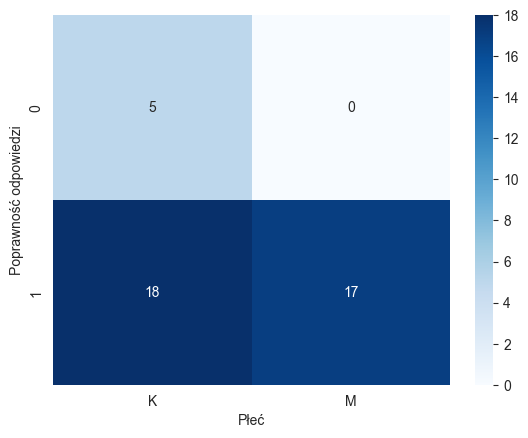

-------------------------------------
1b
Płeć      K   M
1b_corr        
0         2   1
1        21  16
Fisher test conducted...
Fisher test statistic value: 1.5238095238095237
P-value: 1.0
Brak podstaw do odrzucenia H0.


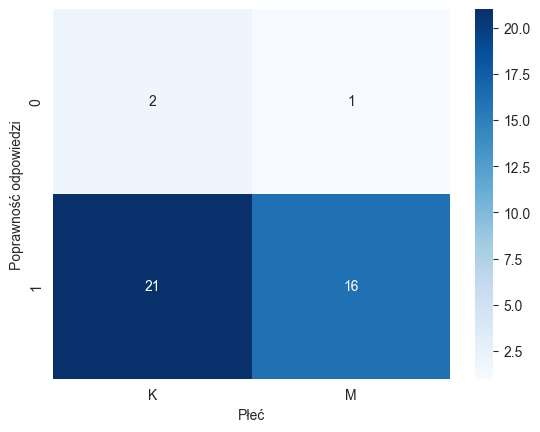

-------------------------------------
2a
Płeć      K   M
2a_corr        
0         7   5
1        16  12
Chi2 test conducted...
Chi-squared test statistic value: 0.00487151382292046
P-value: 0.9443558473117448
Brak podstaw do odrzucenia H0.


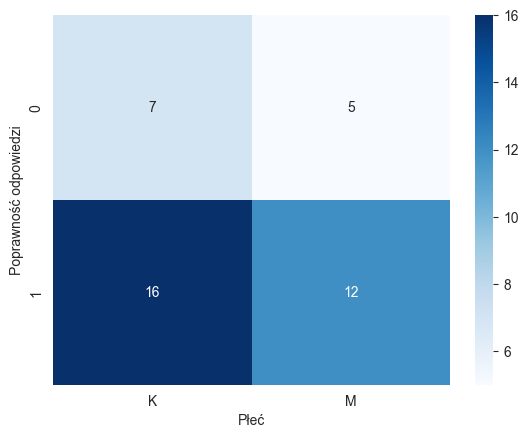

-------------------------------------
2b
Płeć      K   M
2b_corr        
0         5   6
1        18  11
Chi2 test conducted...
Chi-squared test statistic value: 0.9008330059569145
P-value: 0.34255844981552064
Brak podstaw do odrzucenia H0.


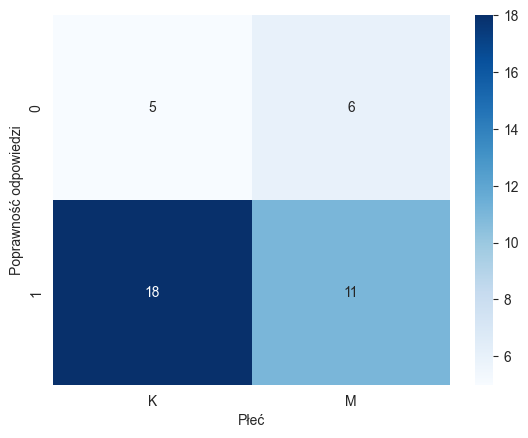

-------------------------------------
3a
Płeć      K   M
3a_corr        
0        12   6
1        11  11
Chi2 test conducted...
Chi-squared test statistic value: 1.1253196930946296
P-value: 0.28877586314715964
Brak podstaw do odrzucenia H0.


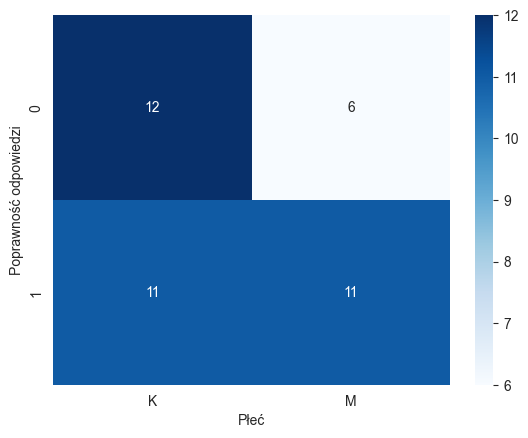

-------------------------------------
3b
Płeć      K   M
3b_corr        
0        15   7
1         8  10
Chi2 test conducted...
Chi-squared test statistic value: 2.2826732801157346
P-value: 0.13082620361130934
Brak podstaw do odrzucenia H0.


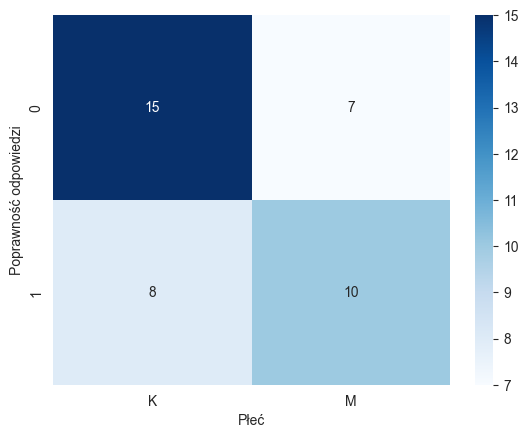

##############################################################
Rok_urodzenia
-------------------------------------
1a
Rok_urodzenia  2000  2001  2002  2003  2004
1a_corr                                    
0                 0     3     1     1     0
1                 1     5    10    16     3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 5.9404125286478235
P-value: 0.203642715501022
Brak podstaw do odrzucenia H0.


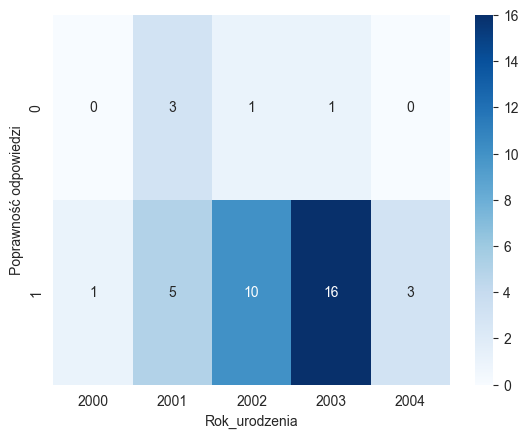

-------------------------------------
1b
Rok_urodzenia  2000  2001  2002  2003  2004
1b_corr                                    
0                 0     2     0     1     0
1                 1     6    11    16     3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.811870694223635
P-value: 0.30715101490609376
Brak podstaw do odrzucenia H0.


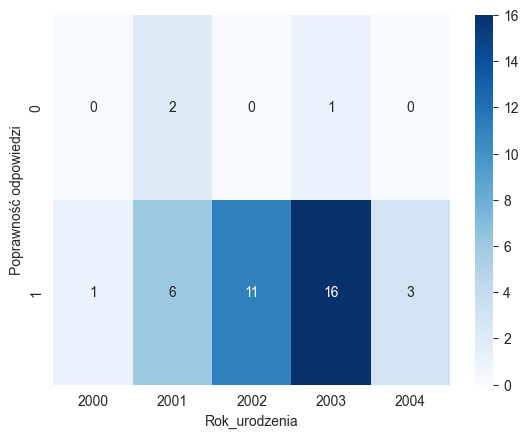

-------------------------------------
2a
Rok_urodzenia  2000  2001  2002  2003  2004
2a_corr                                    
0                 0     2     4     6     0
1                 1     6     7    11     3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.248535777947543
P-value: 0.6901538958509185
Brak podstaw do odrzucenia H0.


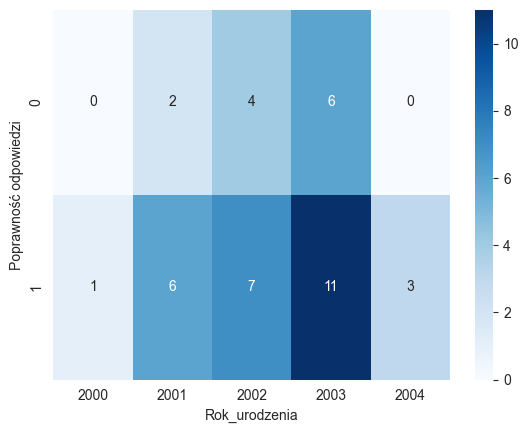

-------------------------------------
2b
Rok_urodzenia  2000  2001  2002  2003  2004
2b_corr                                    
0                 0     2     4     5     0
1                 1     6     7    12     3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.006940137126381
P-value: 0.734482318016528
Brak podstaw do odrzucenia H0.


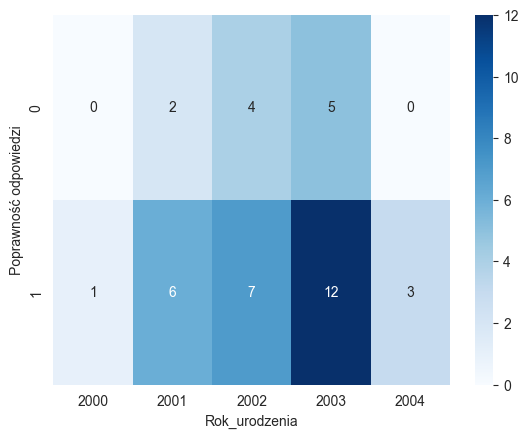

-------------------------------------
3a
Rok_urodzenia  2000  2001  2002  2003  2004
3a_corr                                    
0                 0     3     4    11     0
1                 1     5     7     6     3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 6.453303084319127
P-value: 0.16775654958304373
Brak podstaw do odrzucenia H0.


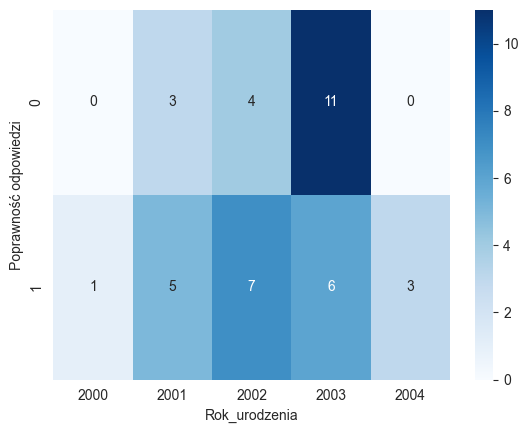

-------------------------------------
3b
Rok_urodzenia  2000  2001  2002  2003  2004
3b_corr                                    
0                 1     5     7     8     1
1                 0     3     4     9     2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.333675435279713
P-value: 0.6746448424458531
Brak podstaw do odrzucenia H0.


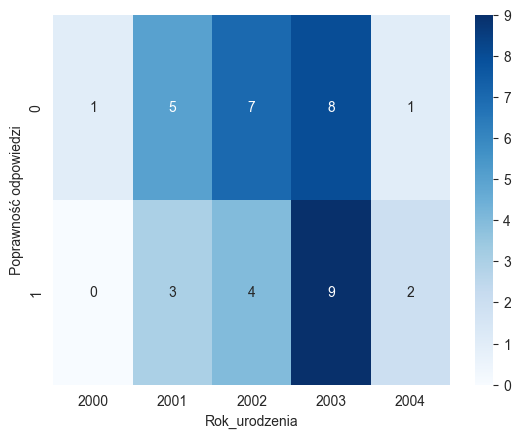

##############################################################
Kierunek_studiów
-------------------------------------
1a
Kierunek_studiów  Geografia  Gospodarka przestrzenna  MISMaP Geografia
1a_corr                                                               
0                         5                        0                 0
1                        27                        5                 3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.4285714285714286
P-value: 0.48954165955695306
Brak podstaw do odrzucenia H0.


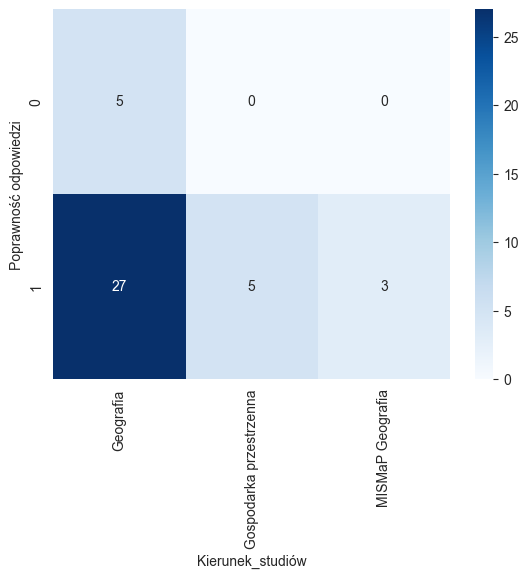

-------------------------------------
1b
Kierunek_studiów  Geografia  Gospodarka przestrzenna  MISMaP Geografia
1b_corr                                                               
0                         3                        0                 0
1                        29                        5                 3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.8108108108108109
P-value: 0.6667064696566672
Brak podstaw do odrzucenia H0.


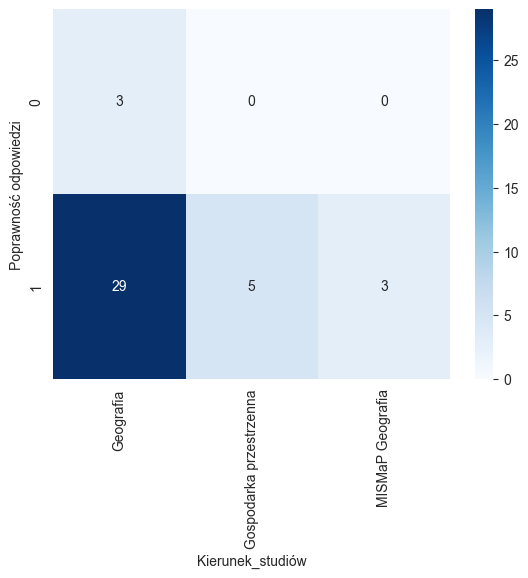

-------------------------------------
2a
Kierunek_studiów  Geografia  Gospodarka przestrzenna  MISMaP Geografia
2a_corr                                                               
0                         9                        2                 1
1                        23                        3                 2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.30753968253968256
P-value: 0.857469352359109
Brak podstaw do odrzucenia H0.


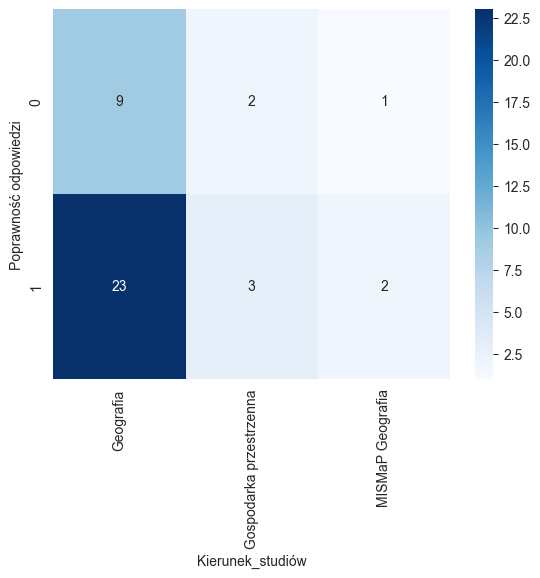

-------------------------------------
2b
Kierunek_studiów  Geografia  Gospodarka przestrzenna  MISMaP Geografia
2b_corr                                                               
0                         7                        2                 2
1                        25                        3                 1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.207941483803553
P-value: 0.20109642855639676
Brak podstaw do odrzucenia H0.


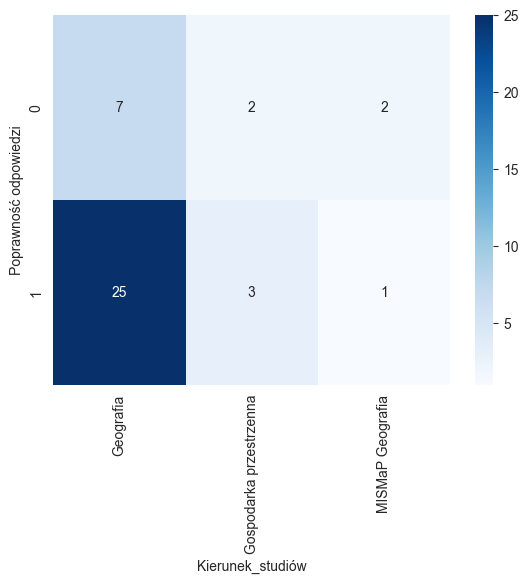

-------------------------------------
3a
Kierunek_studiów  Geografia  Gospodarka przestrzenna  MISMaP Geografia
3a_corr                                                               
0                        15                        3                 0
1                        17                        2                 3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.954545454545455
P-value: 0.22825936579963474
Brak podstaw do odrzucenia H0.


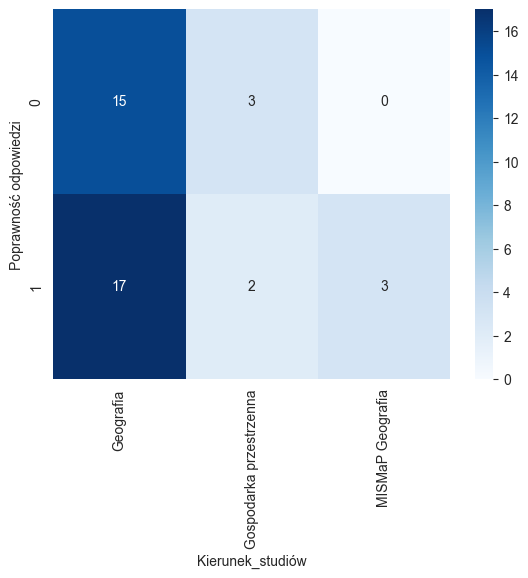

-------------------------------------
3b
Kierunek_studiów  Geografia  Gospodarka przestrzenna  MISMaP Geografia
3b_corr                                                               
0                        19                        3                 0
1                        13                        2                 3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.9646464646464636
P-value: 0.13774884271557652
Brak podstaw do odrzucenia H0.


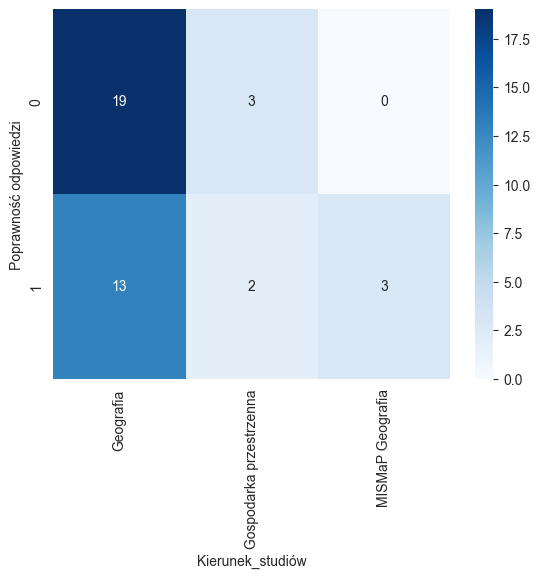

##############################################################
Rok_studiów
-------------------------------------
1a
Rok_studiów   1  2  3
1a_corr              
0             3  0  2
1            20  8  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.9268461007591442
P-value: 0.38158446500947457
Brak podstaw do odrzucenia H0.


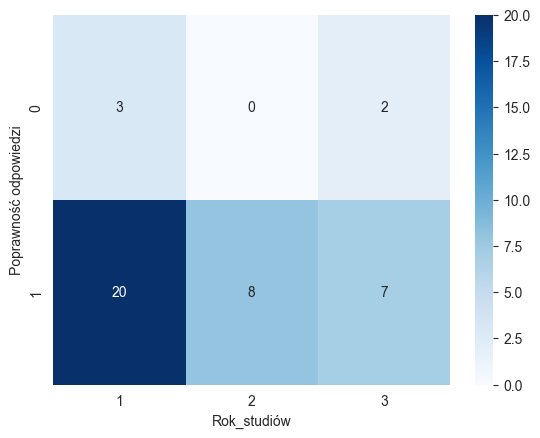

-------------------------------------
1b
Rok_studiów   1  2  3
1b_corr              
0             2  0  1
1            21  8  8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.8652130391260824
P-value: 0.6488157378845619
Brak podstaw do odrzucenia H0.


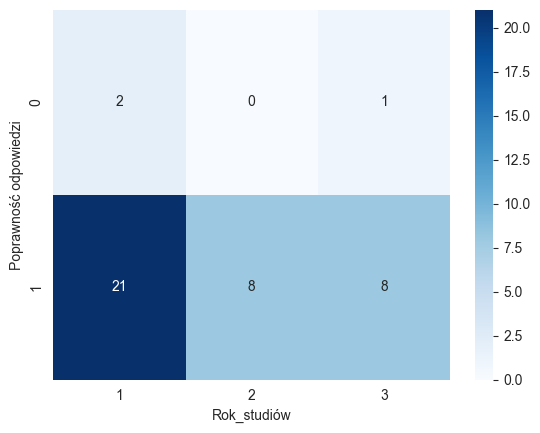

-------------------------------------
2a
Rok_studiów   1  2  3
2a_corr              
0             8  3  1
1            15  5  8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.993903841729929
P-value: 0.3690024775025993
Brak podstaw do odrzucenia H0.


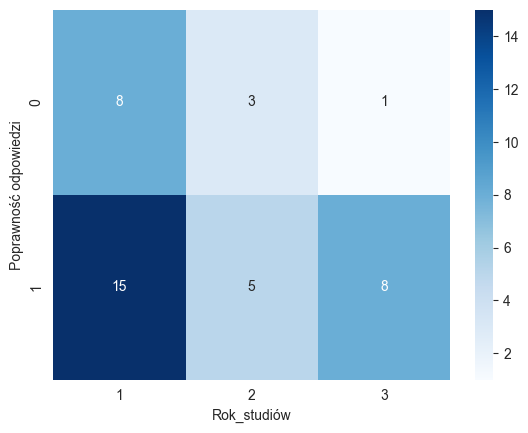

-------------------------------------
2b
Rok_studiów   1  2  3
2b_corr              
0             7  3  1
1            16  5  8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.713082852513137
P-value: 0.424628153380916
Brak podstaw do odrzucenia H0.


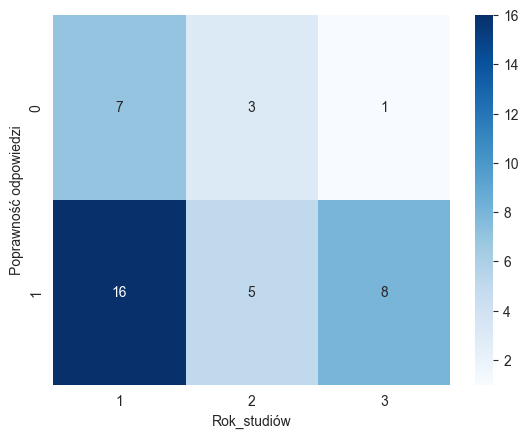

-------------------------------------
3a
Rok_studiów   1  2  3
3a_corr              
0            13  3  2
1            10  5  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.3021031571756208
P-value: 0.19184805919792383
Brak podstaw do odrzucenia H0.


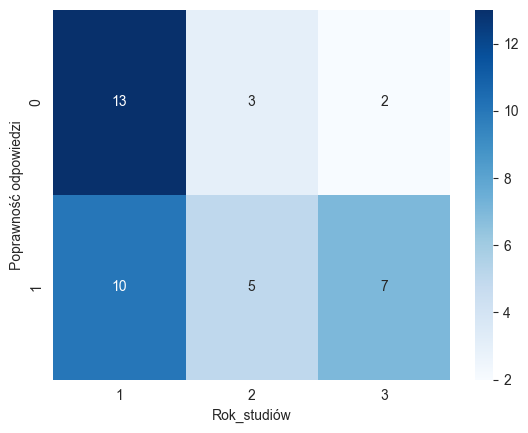

-------------------------------------
3b
Rok_studiów   1  2  3
3b_corr              
0            12  5  5
1            11  3  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.257160981798663
P-value: 0.8793427804785817
Brak podstaw do odrzucenia H0.


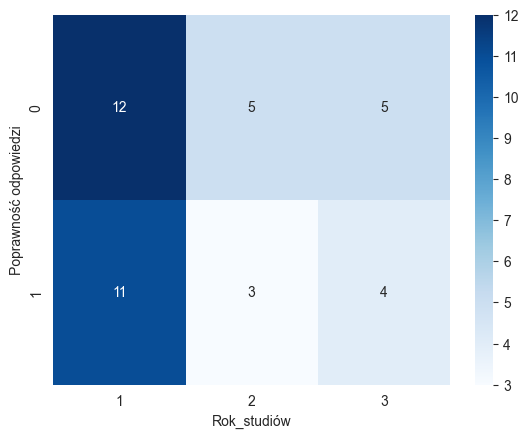

##############################################################
Specjalność
-------------------------------------
1a
Specjalność  FIZ   GEOINF   NO_VAL  SPOŁ-EKO
1a_corr                                     
0               2        3       0         0
1               7       15       5         8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.9206349206349205
P-value: 0.4040242683837014
Brak podstaw do odrzucenia H0.


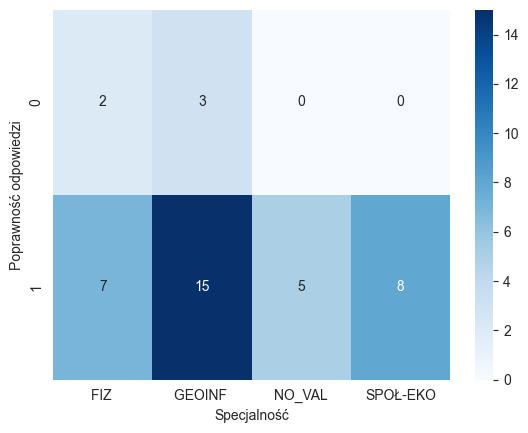

-------------------------------------
1b
Specjalność  FIZ   GEOINF   NO_VAL  SPOŁ-EKO
1b_corr                                     
0               1        2       0         0
1               8       16       5         8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.561561561561561
P-value: 0.6681365350498931
Brak podstaw do odrzucenia H0.


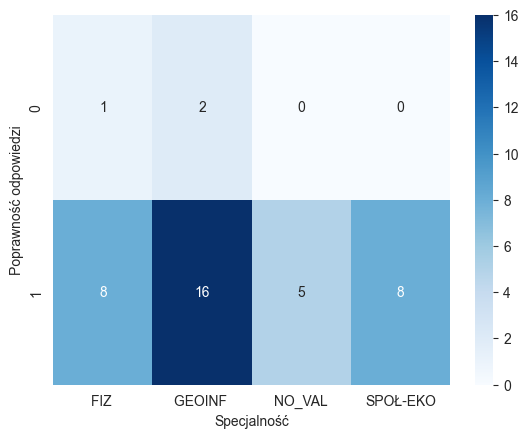

-------------------------------------
2a
Specjalność  FIZ   GEOINF   NO_VAL  SPOŁ-EKO
2a_corr                                     
0               3        3       2         4
1               6       15       3         4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.333333333333334
P-value: 0.3430301461382424
Brak podstaw do odrzucenia H0.


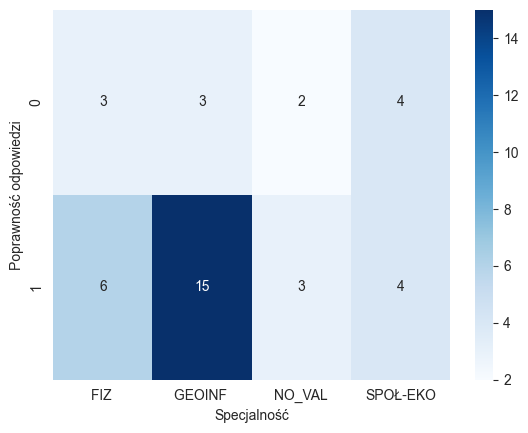

-------------------------------------
2b
Specjalność  FIZ   GEOINF   NO_VAL  SPOŁ-EKO
2b_corr                                     
0               2        4       2         3
1               7       14       3         5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.1703239289446183
P-value: 0.7601302997790985
Brak podstaw do odrzucenia H0.


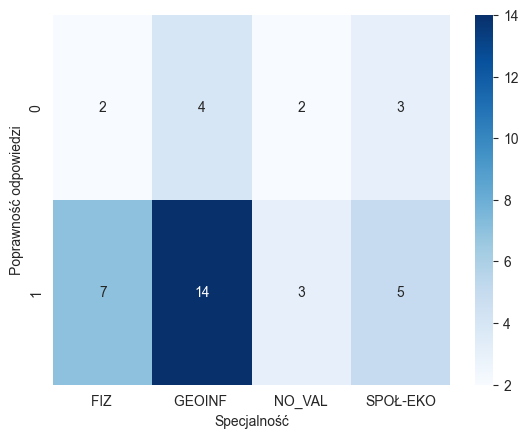

-------------------------------------
3a
Specjalność  FIZ   GEOINF   NO_VAL  SPOŁ-EKO
3a_corr                                     
0               5        7       3         3
1               4       11       2         5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.3131313131313131
P-value: 0.7260173030217615
Brak podstaw do odrzucenia H0.


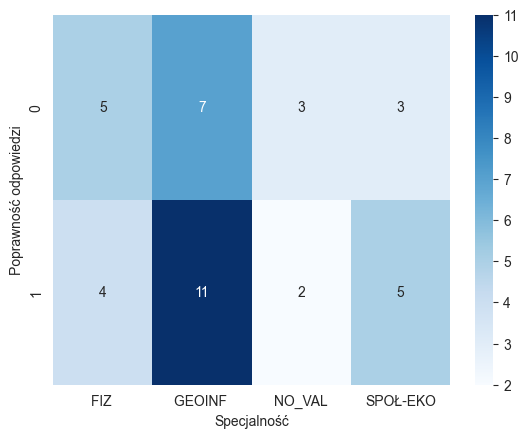

-------------------------------------
3b
Specjalność  FIZ   GEOINF   NO_VAL  SPOŁ-EKO
3b_corr                                     
0               6       10       3         3
1               3        8       2         5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.5375982042648708
P-value: 0.673620262740217
Brak podstaw do odrzucenia H0.


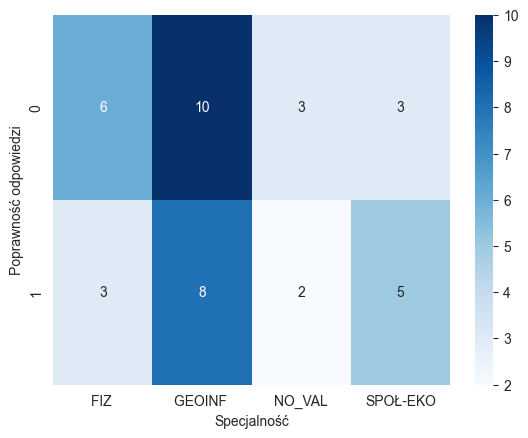

##############################################################
Wady_wzroku
-------------------------------------
1a
Wady_wzroku   0   1
1a_corr            
0             2   3
1            14  21
Fisher test conducted...
Fisher test statistic value: 1.0
P-value: 1.0
Brak podstaw do odrzucenia H0.


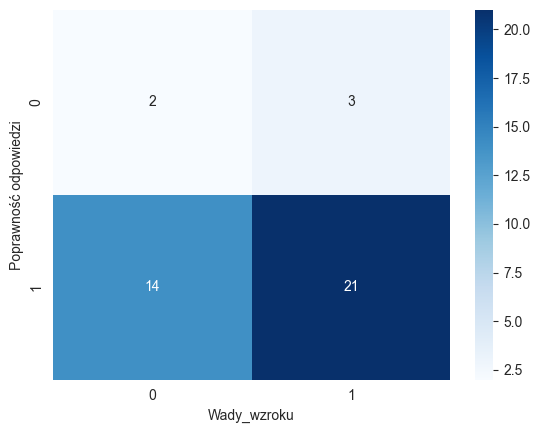

-------------------------------------
1b
Wady_wzroku   0   1
1b_corr            
0             2   1
1            14  23
Fisher test conducted...
Fisher test statistic value: 3.2857142857142856
P-value: 0.5530364372469635
Brak podstaw do odrzucenia H0.


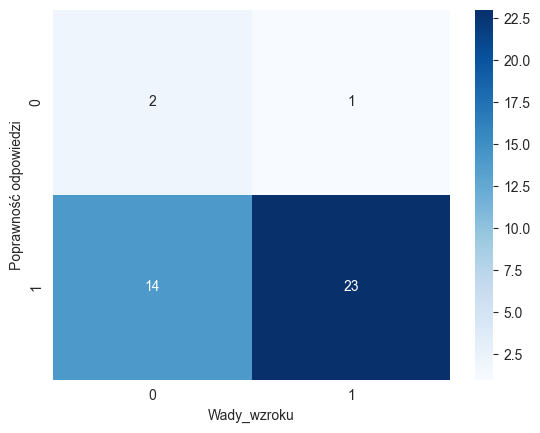

-------------------------------------
2a
Wady_wzroku   0   1
2a_corr            
0             4   8
1            12  16
Fisher test conducted...
Fisher test statistic value: 0.6666666666666666
P-value: 0.7294036298943712
Brak podstaw do odrzucenia H0.


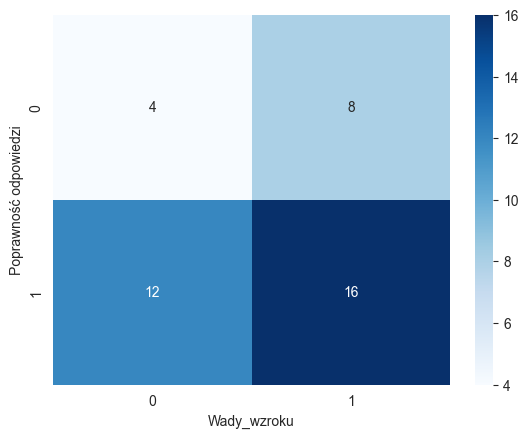

-------------------------------------
2b
Wady_wzroku   0   1
2b_corr            
0             3   8
1            13  16
Fisher test conducted...
Fisher test statistic value: 0.46153846153846156
P-value: 0.4732140109749217
Brak podstaw do odrzucenia H0.


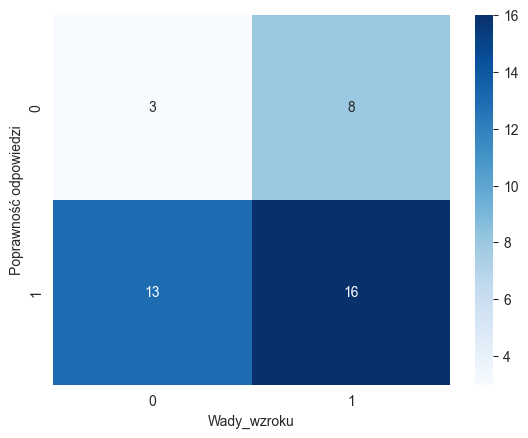

-------------------------------------
3a
Wady_wzroku   0   1
3a_corr            
0             6  12
1            10  12
Chi2 test conducted...
Chi-squared test statistic value: 0.6060606060606056
P-value: 0.4362749288405292
Brak podstaw do odrzucenia H0.


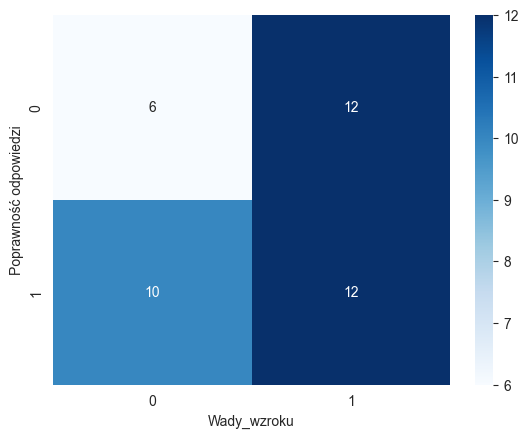

-------------------------------------
3b
Wady_wzroku  0   1
3b_corr           
0            9  13
1            7  11
Chi2 test conducted...
Chi-squared test statistic value: 0.016835016835016765
P-value: 0.8967643618426943
Brak podstaw do odrzucenia H0.


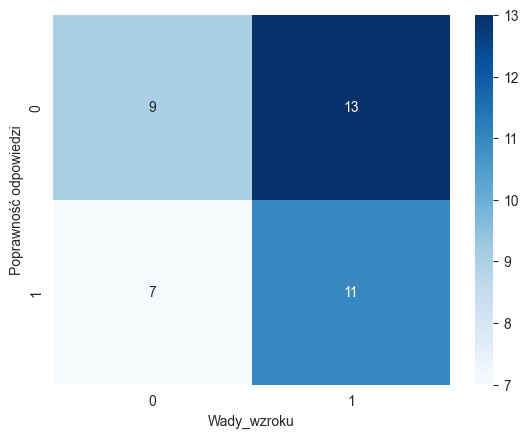

##############################################################
Ilość_snu
-------------------------------------
1a
Ilość_snu   6  7  8  8<  <6
1a_corr                    
0           1  1  0   1   2
1          10  8  4   5   8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.3137085137085138
P-value: 0.8590454239933245
Brak podstaw do odrzucenia H0.


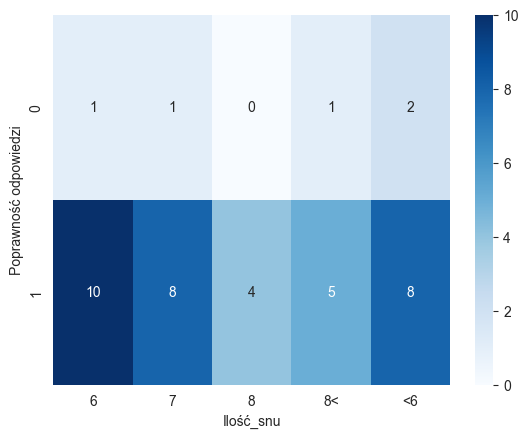

-------------------------------------
1b
Ilość_snu   6  7  8  8<  <6
1b_corr                    
0           1  0  0   1   1
1          10  9  4   5   9
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.9110019110019112
P-value: 0.7521236414952284
Brak podstaw do odrzucenia H0.


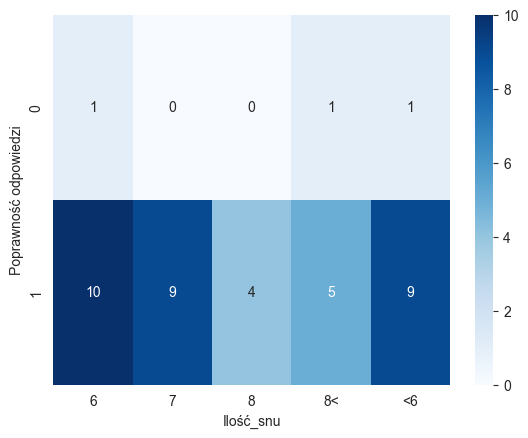

-------------------------------------
2a
Ilość_snu  6  7  8  8<  <6
2a_corr                   
0          5  1  0   3   3
1          6  8  4   3   7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 5.637325637325637
P-value: 0.22791956330496121
Brak podstaw do odrzucenia H0.


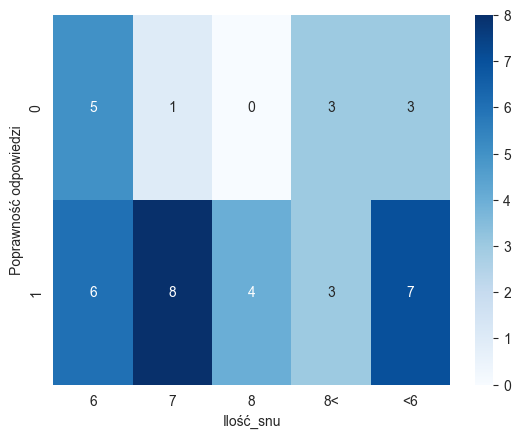

-------------------------------------
2b
Ilość_snu  6  7  8  8<  <6
2b_corr                   
0          5  2  0   3   1
1          6  7  4   3   9
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 6.481112061049366
P-value: 0.16598437349911374
Brak podstaw do odrzucenia H0.


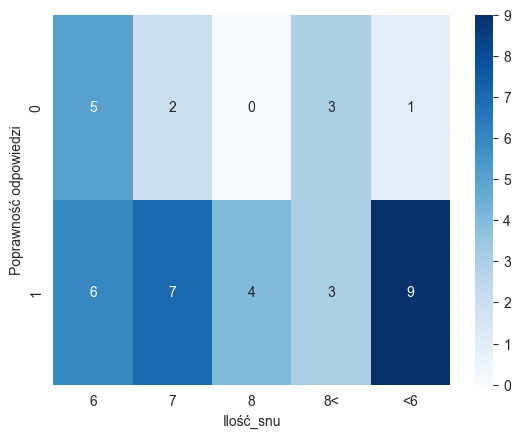

-------------------------------------
3a
Ilość_snu  6  7  8  8<  <6
3a_corr                   
0          5  3  1   3   6
1          6  6  3   3   4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.112029384756657
P-value: 0.7151627078769266
Brak podstaw do odrzucenia H0.


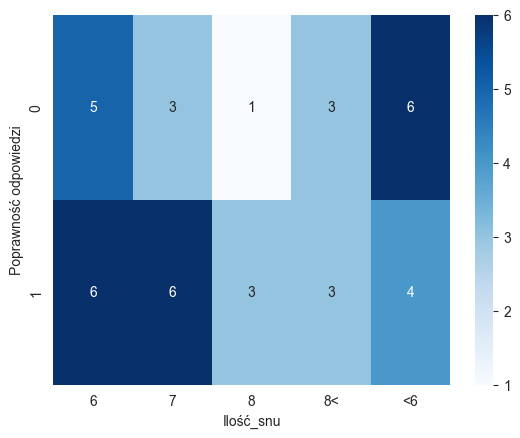

-------------------------------------
3b
Ilość_snu  6  7  8  8<  <6
3b_corr                   
0          5  4  3   5   5
1          6  5  1   1   5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.5037241097847156
P-value: 0.47731231139165786
Brak podstaw do odrzucenia H0.


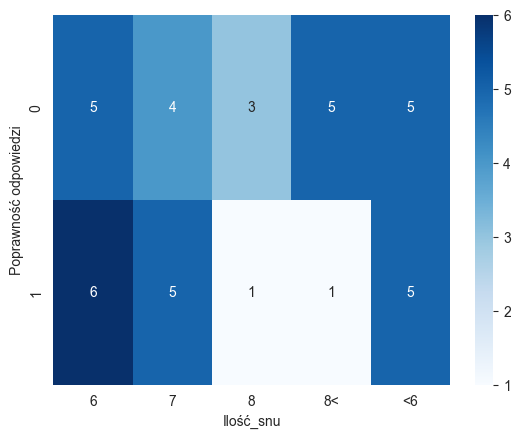

##############################################################
JP_podst
-------------------------------------
1a
JP_podst  1   2   3  4
1a_corr               
0         1   1   2  1
1         4  12  15  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.7974143503555268
P-value: 0.8500853862664508
Brak podstaw do odrzucenia H0.


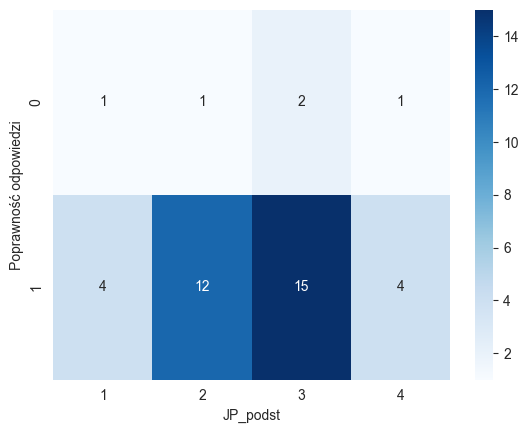

-------------------------------------
1b
JP_podst  1   2   3  4
1b_corr               
0         1   1   1  0
1         4  12  16  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.59634747870042
P-value: 0.6602182877558944
Brak podstaw do odrzucenia H0.


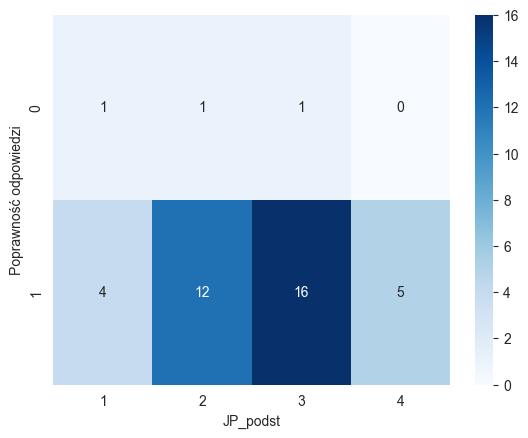

-------------------------------------
2a
JP_podst  1  2   3  4
2a_corr              
0         3  4   4  1
1         2  9  13  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.7235509588450766
P-value: 0.4362398808318344
Brak podstaw do odrzucenia H0.


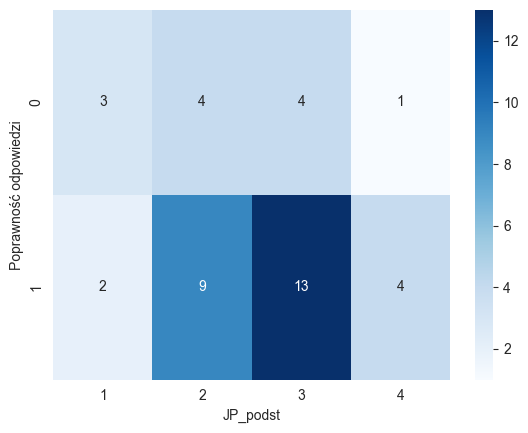

-------------------------------------
2b
JP_podst  1   2   3  4
2b_corr               
0         3   2   3  3
1         2  11  14  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 7.082653654661768
P-value: 0.06930946310020905
Brak podstaw do odrzucenia H0.


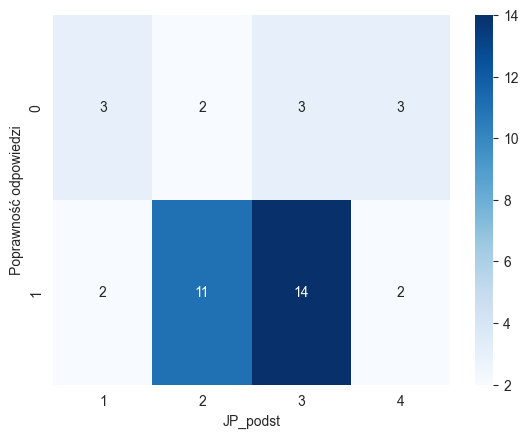

-------------------------------------
3a
JP_podst  1  2   3  4
3a_corr              
0         3  7   6  2
1         2  6  11  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.5631427396133284
P-value: 0.6677755245435393
Brak podstaw do odrzucenia H0.


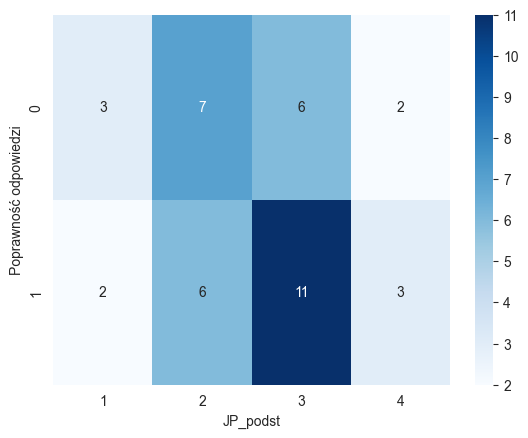

-------------------------------------
3b
JP_podst  1  2  3  4
3b_corr             
0         4  8  8  2
1         1  5  9  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.374880021938845
P-value: 0.49832782751672644
Brak podstaw do odrzucenia H0.


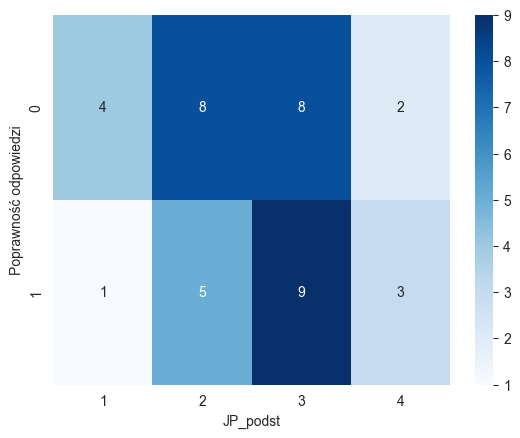

##############################################################
MAT_podst
-------------------------------------
1a
MAT_podst  1  2  3   4
1a_corr               
0          0  0  3   2
1          1  3  9  22
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.666666666666666
P-value: 0.4459216983631228
Brak podstaw do odrzucenia H0.


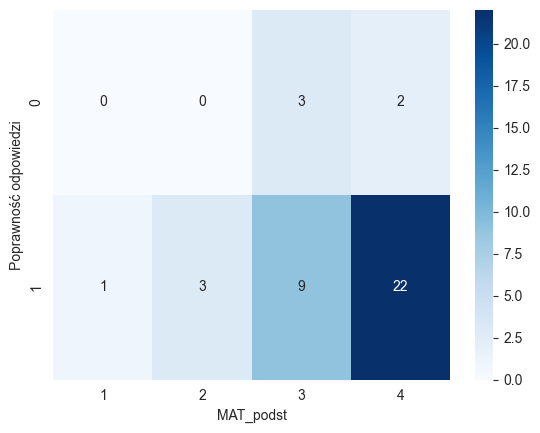

-------------------------------------
1b
MAT_podst  1  2   3   4
1b_corr                
0          0  0   2   1
1          1  3  10  23
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.1621621621621623
P-value: 0.5394396458616231
Brak podstaw do odrzucenia H0.


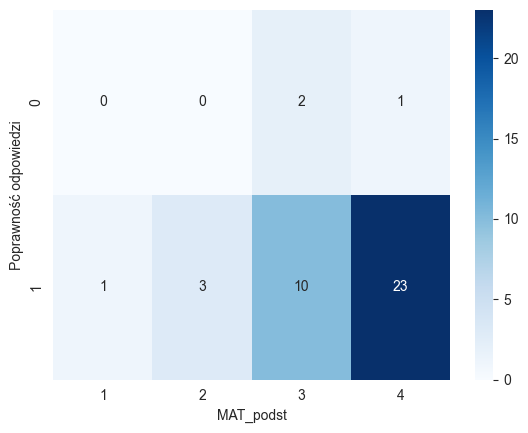

-------------------------------------
2a
MAT_podst  1  2  3   4
2a_corr               
0          0  1  4   7
1          1  2  8  17
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.5158730158730159
P-value: 0.9153905943014297
Brak podstaw do odrzucenia H0.


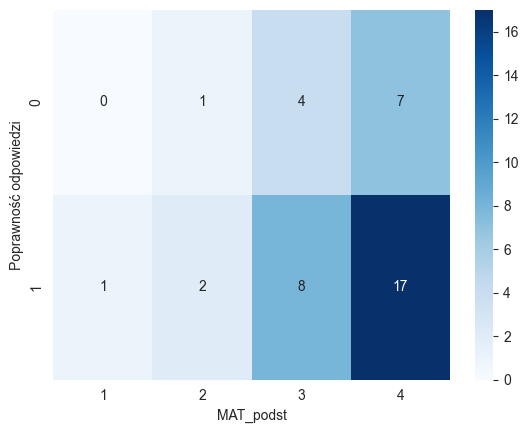

-------------------------------------
2b
MAT_podst  1  2  3   4
2b_corr               
0          0  0  4   7
1          1  3  8  17
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.7554858934169282
P-value: 0.6246692705055594
Brak podstaw do odrzucenia H0.


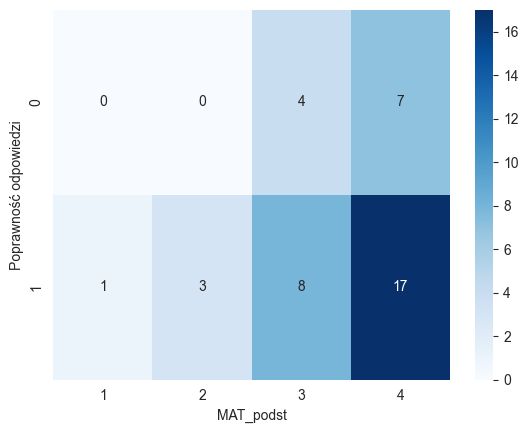

-------------------------------------
3a
MAT_podst  1  2  3   4
3a_corr               
0          1  2  6   9
1          0  1  6  15
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.4579124579124585
P-value: 0.4829452831917367
Brak podstaw do odrzucenia H0.


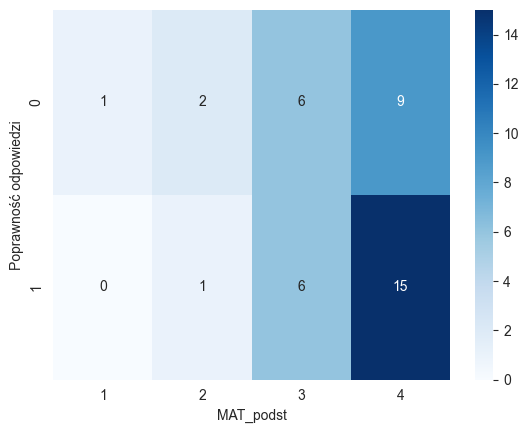

-------------------------------------
3b
MAT_podst  1  2   3   4
3b_corr                
0          1  2  10   9
1          0  1   2  15
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 7.845117845117845
P-value: 0.04932348789656462
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.


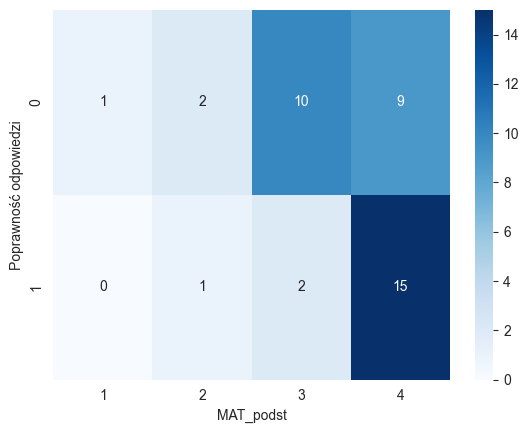

##############################################################
JP_roz
-------------------------------------
1a
JP_roz    0  2  3  4
1a_corr             
0         4  0  0  1
1        27  1  5  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.0522273425499233
P-value: 0.5616377867991533
Brak podstaw do odrzucenia H0.


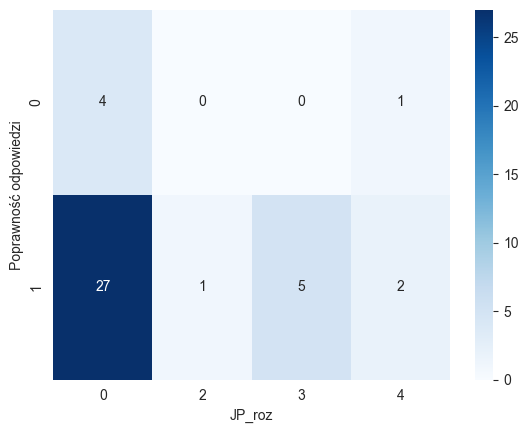

-------------------------------------
1b
JP_roz    0  2  3  4
1b_corr             
0         3  0  0  0
1        28  1  5  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.9415867480383608
P-value: 0.8153821142577709
Brak podstaw do odrzucenia H0.


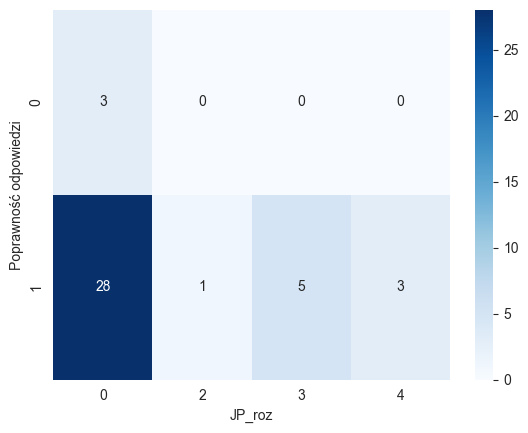

-------------------------------------
2a
JP_roz    0  2  3  4
2a_corr             
0         8  1  2  1
1        23  0  3  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.846902201740911
P-value: 0.4158370645047611
Brak podstaw do odrzucenia H0.


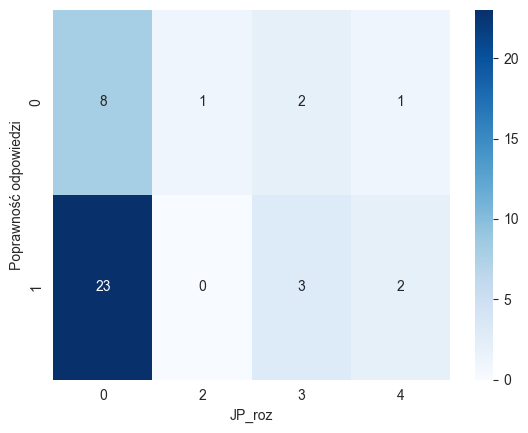

-------------------------------------
2b
JP_roz    0  2  3  4
2b_corr             
0         8  0  2  1
1        23  1  3  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.8669565510499883
P-value: 0.8333937288913041
Brak podstaw do odrzucenia H0.


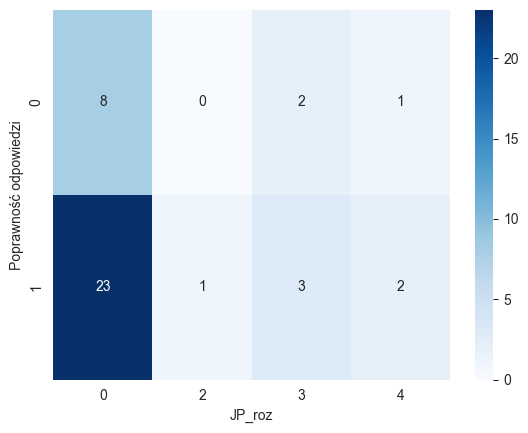

-------------------------------------
3a
JP_roz    0  2  3  4
3a_corr             
0        14  0  2  2
1        17  1  3  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.4380362767459538
P-value: 0.6966435341871706
Brak podstaw do odrzucenia H0.


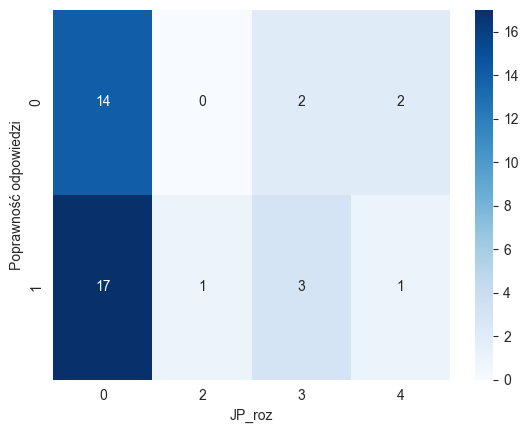

-------------------------------------
3b
JP_roz    0  2  3  4
3b_corr             
0        18  0  2  2
1        13  1  3  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.959378733572282
P-value: 0.5808804610607898
Brak podstaw do odrzucenia H0.


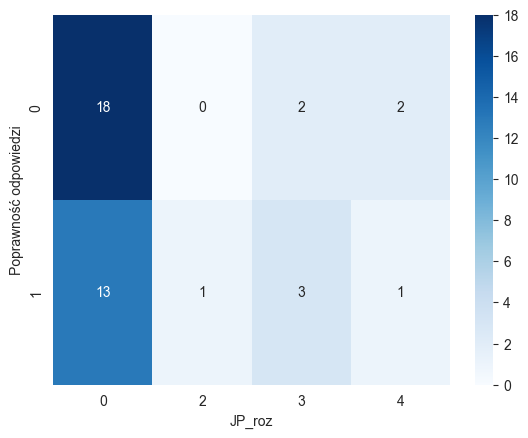

##############################################################
MAT_roz
-------------------------------------
1a
MAT_roz   0  1  2   3  4
1a_corr                 
0         4  0  0   0  1
1        14  5  2  10  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.241269841269842
P-value: 0.3743371416697125
Brak podstaw do odrzucenia H0.


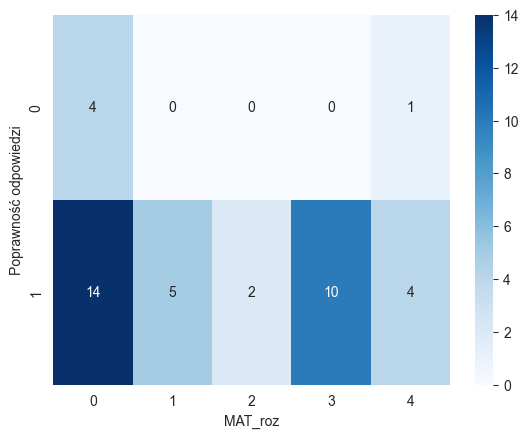

-------------------------------------
1b
MAT_roz   0  1  2   3  4
1b_corr                 
0         2  0  0   0  1
1        16  5  2  10  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.842842842842843
P-value: 0.5844601434915346
Brak podstaw do odrzucenia H0.


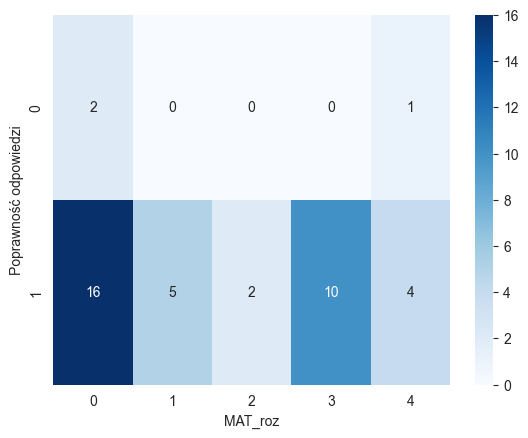

-------------------------------------
2a
MAT_roz   0  1  2  3  4
2a_corr                
0         4  3  0  4  1
1        14  2  2  6  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.2328042328042335
P-value: 0.375415094018582
Brak podstaw do odrzucenia H0.


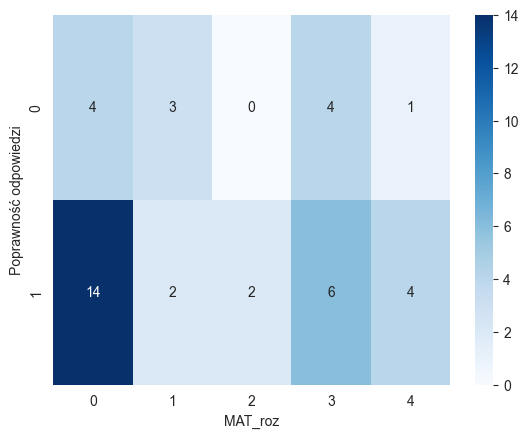

-------------------------------------
2b
MAT_roz   0  1  2  3  4
2b_corr                
0         3  2  1  4  1
1        15  3  1  6  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.884012539184953
P-value: 0.577419450189052
Brak podstaw do odrzucenia H0.


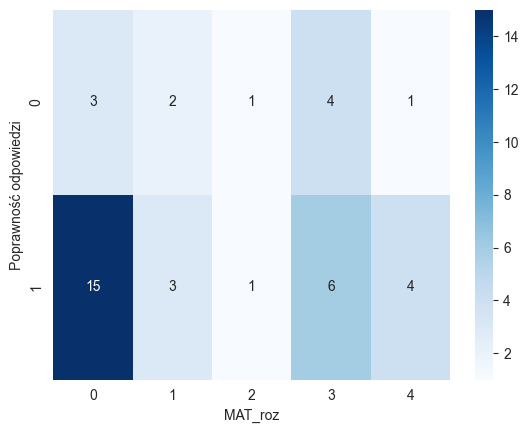

-------------------------------------
3a
MAT_roz  0  1  2  3  4
3a_corr               
0        9  3  1  5  0
1        9  2  1  5  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.8484848484848495
P-value: 0.30320013893153425
Brak podstaw do odrzucenia H0.


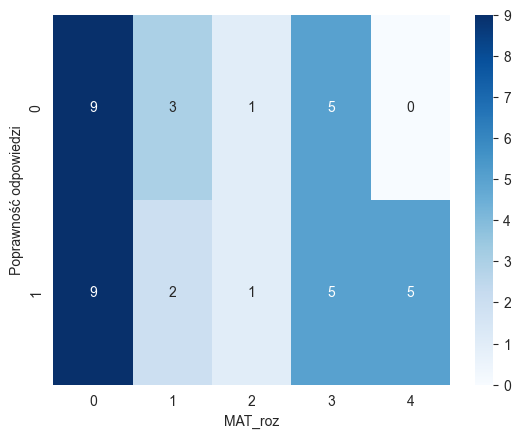

-------------------------------------
3b
MAT_roz   0  1  2  3  4
3b_corr                
0        11  4  0  4  3
1         7  1  2  6  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.938271604938271
P-value: 0.2936900592954435
Brak podstaw do odrzucenia H0.


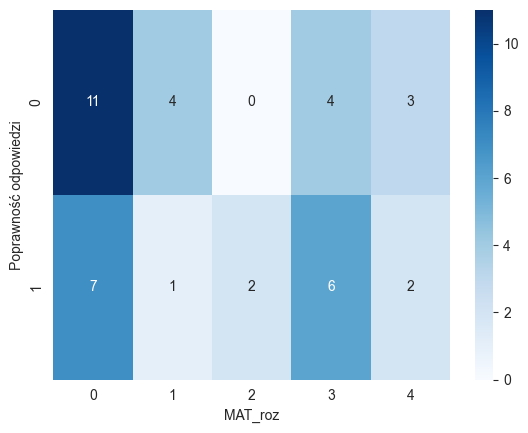

##############################################################
FIZ_roz
-------------------------------------
1a
FIZ_roz   0
1a_corr    
0         5
1        35
Chi2 test conducted...
Chi-squared test statistic value: 0.0
P-value: 1.0
Brak podstaw do odrzucenia H0.


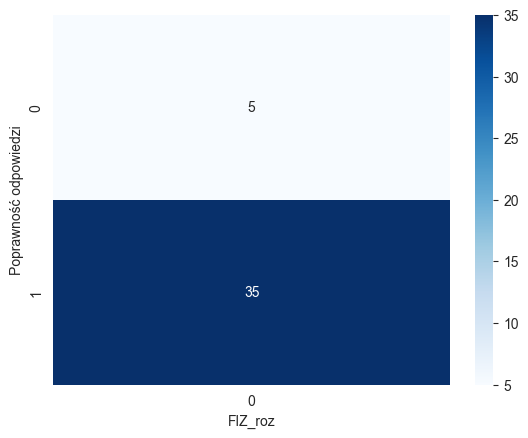

-------------------------------------
1b
FIZ_roz   0
1b_corr    
0         3
1        37
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.0
P-value: 1.0
Brak podstaw do odrzucenia H0.


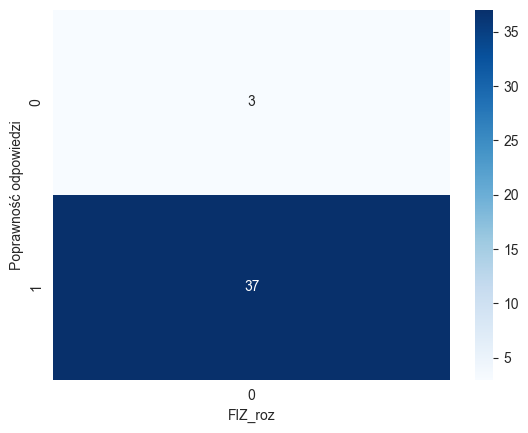

-------------------------------------
2a
FIZ_roz   0
2a_corr    
0        12
1        28
Chi2 test conducted...
Chi-squared test statistic value: 0.0
P-value: 1.0
Brak podstaw do odrzucenia H0.


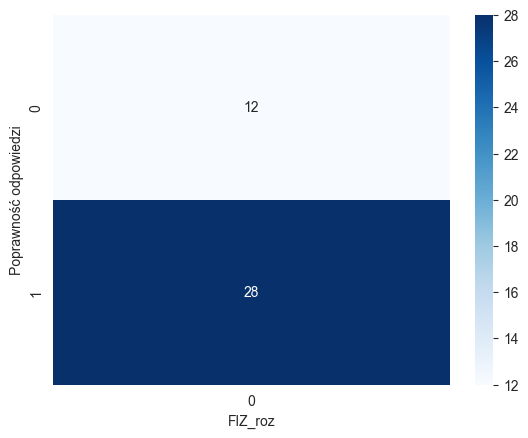

-------------------------------------
2b
FIZ_roz   0
2b_corr    
0        11
1        29
Chi2 test conducted...
Chi-squared test statistic value: 0.0
P-value: 1.0
Brak podstaw do odrzucenia H0.


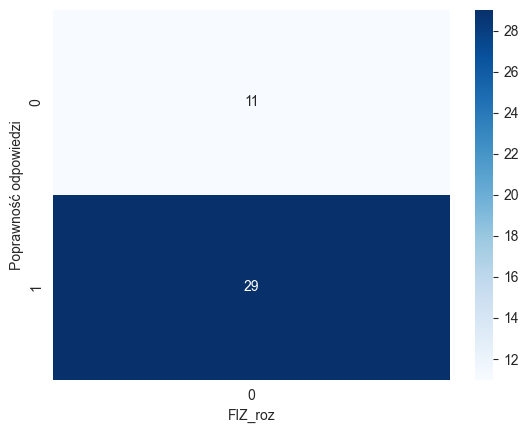

-------------------------------------
3a
FIZ_roz   0
3a_corr    
0        18
1        22
Chi2 test conducted...
Chi-squared test statistic value: 0.0
P-value: 1.0
Brak podstaw do odrzucenia H0.


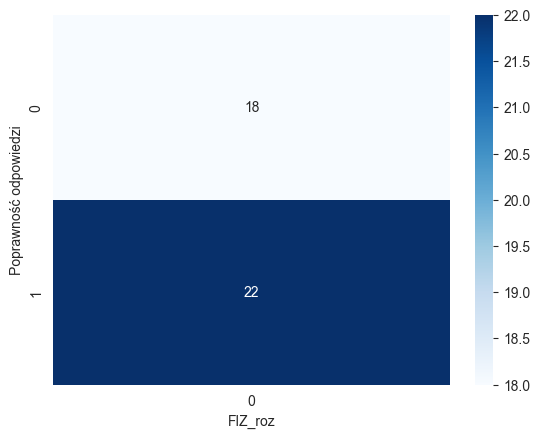

-------------------------------------
3b
FIZ_roz   0
3b_corr    
0        22
1        18
Chi2 test conducted...
Chi-squared test statistic value: 0.0
P-value: 1.0
Brak podstaw do odrzucenia H0.


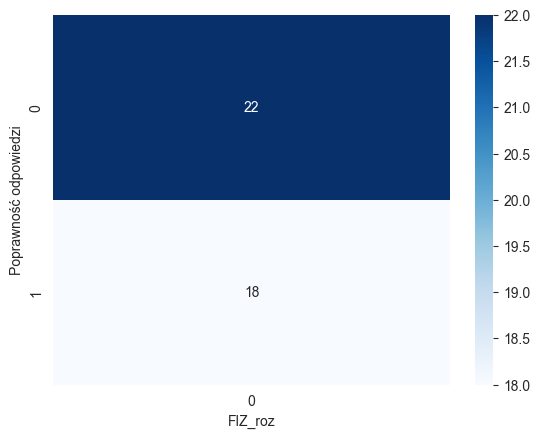

##############################################################
HIST_roz
-------------------------------------
1a
HIST_roz   0  2  4
1a_corr           
0          5  0  0
1         31  1  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.634920634920635
P-value: 0.7279955689141826
Brak podstaw do odrzucenia H0.


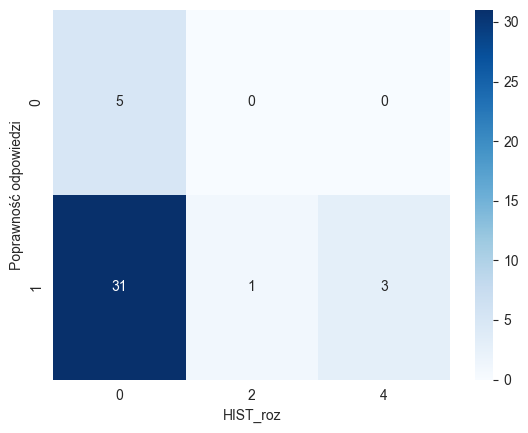

-------------------------------------
1b
HIST_roz   0  2  4
1b_corr           
0          3  0  0
1         33  1  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.3603603603603603
P-value: 0.8351197258317473
Brak podstaw do odrzucenia H0.


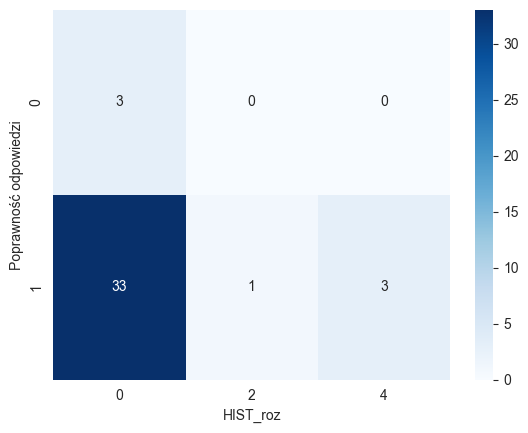

-------------------------------------
2a
HIST_roz   0  2  4
2a_corr           
0         11  1  0
1         25  0  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.6243386243386237
P-value: 0.16329950468513624
Brak podstaw do odrzucenia H0.


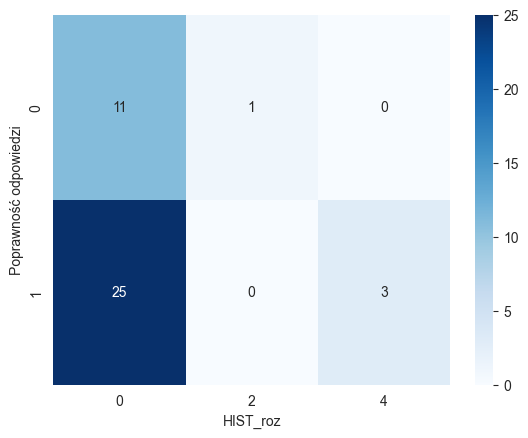

-------------------------------------
2b
HIST_roz   0  2  4
2b_corr           
0         10  0  1
1         26  1  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.43190525949146646
P-value: 0.8057734706636266
Brak podstaw do odrzucenia H0.


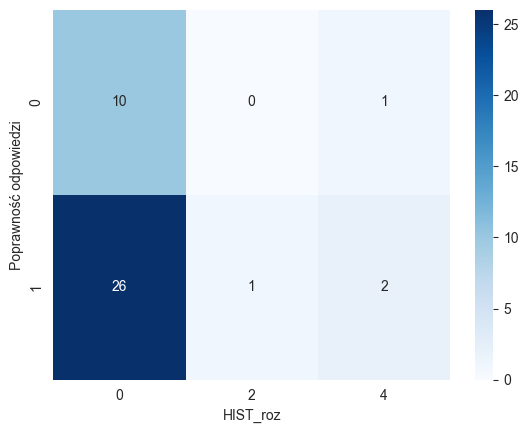

-------------------------------------
3a
HIST_roz   0  2  4
3a_corr           
0         18  0  0
1         18  1  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.6363636363636367
P-value: 0.1623206111818482
Brak podstaw do odrzucenia H0.


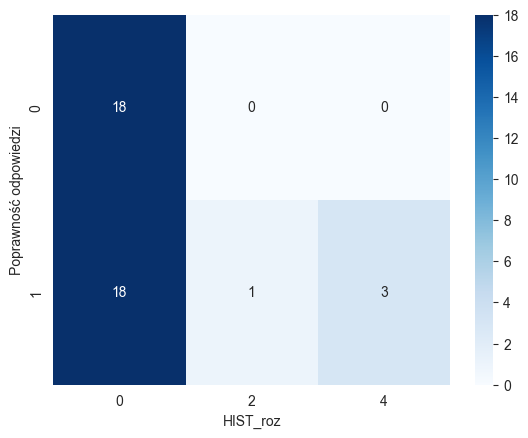

-------------------------------------
3b
HIST_roz   0  2  4
3b_corr           
0         20  1  1
1         16  0  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.391694725028058
P-value: 0.4986517301291298
Brak podstaw do odrzucenia H0.


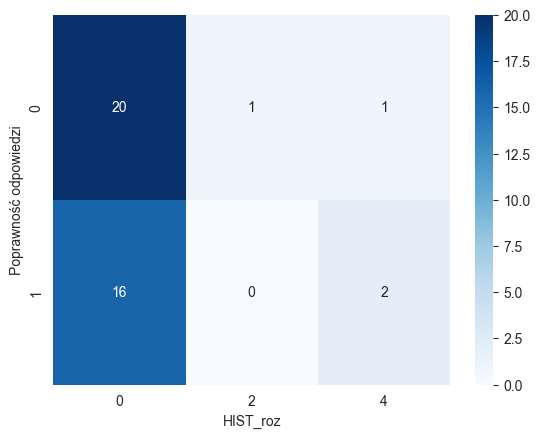

##############################################################
Samopocz
-------------------------------------
1a
Samopocz  2  3   4  5
1a_corr              
0         2  1   2  0
1         3  5  18  9
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.9523809523809526
P-value: 0.17531743847654538
Brak podstaw do odrzucenia H0.


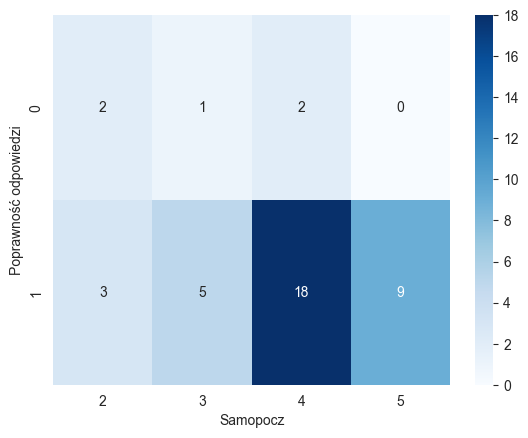

-------------------------------------
1b
Samopocz  2  3   4  5
1b_corr              
0         1  0   1  1
1         4  6  19  8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.961961961961962
P-value: 0.580339057639008
Brak podstaw do odrzucenia H0.


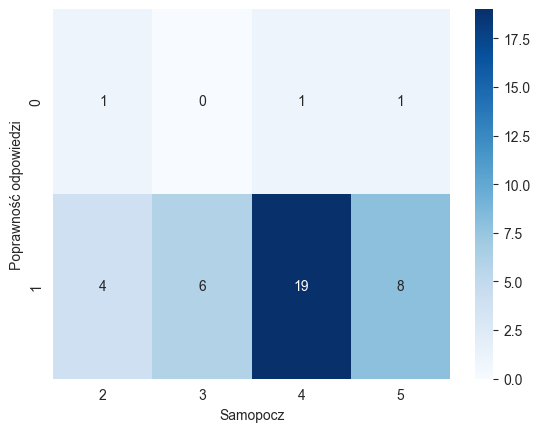

-------------------------------------
2a
Samopocz  2  3   4  5
2a_corr              
0         2  3   4  3
1         3  3  16  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.380952380952381
P-value: 0.49719017971055923
Brak podstaw do odrzucenia H0.


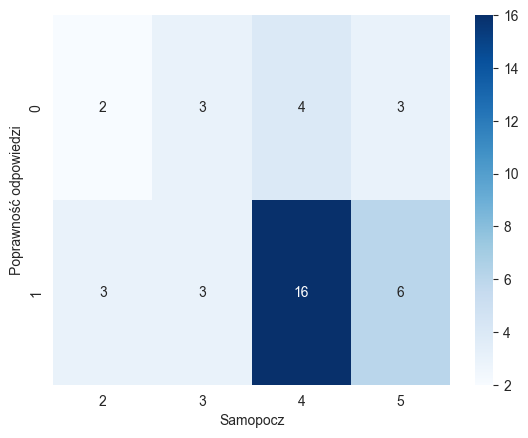

-------------------------------------
2b
Samopocz  2  3   4  5
2b_corr              
0         2  3   4  2
1         3  3  16  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.6053639846743297
P-value: 0.4565499470147082
Brak podstaw do odrzucenia H0.


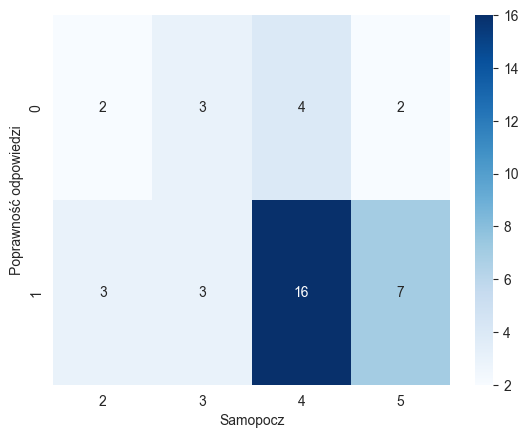

-------------------------------------
3a
Samopocz  2  3   4  5
3a_corr              
0         5  5   1  7
1         0  1  19  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 26.509539842873174
P-value: 7.459508639904343e-06
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.


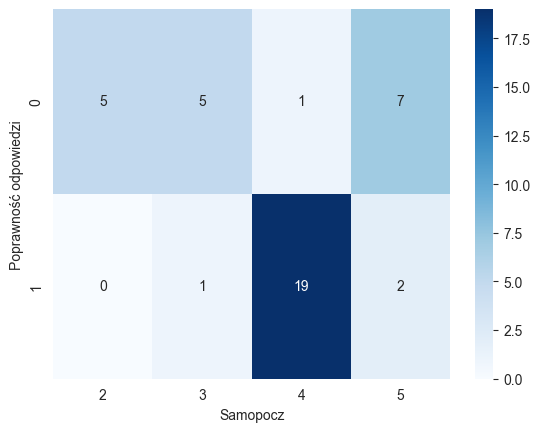

-------------------------------------
3b
Samopocz  2  3   4  5
3b_corr              
0         3  3   8  8
1         2  3  12  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 6.105499438832771
P-value: 0.10658875349940074
Brak podstaw do odrzucenia H0.


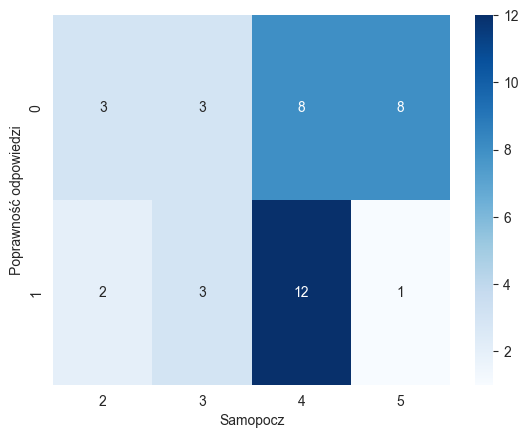

##############################################################
Stres
-------------------------------------
1a
Stres    1   2  3  4  5
1a_corr                
0        0   1  1  1  2
1        9  14  8  4  0
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 16.025396825396825
P-value: 0.0029852735492366307
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.


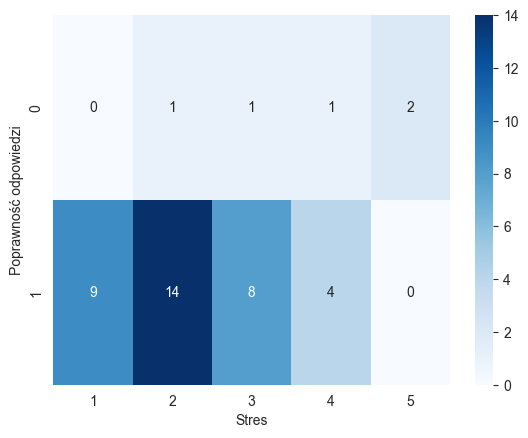

-------------------------------------
1b
Stres    1   2  3  4  5
1b_corr                
0        1   0  1  0  1
1        8  15  8  5  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 7.167167167167167
P-value: 0.12731353574488088
Brak podstaw do odrzucenia H0.


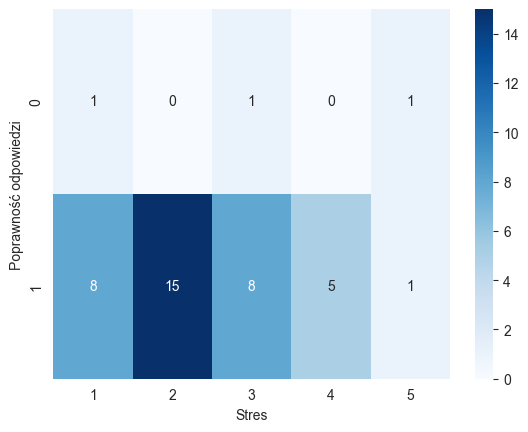

-------------------------------------
2a
Stres    1   2  3  4  5
2a_corr                
0        3   3  4  1  1
1        6  12  5  4  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.275132275132275
P-value: 0.6853002095138743
Brak podstaw do odrzucenia H0.


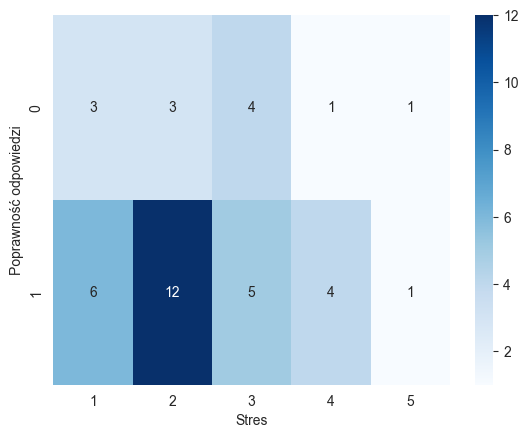

-------------------------------------
2b
Stres    1   2  3  4  5
2b_corr                
0        2   3  3  2  1
1        7  12  6  3  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.6022291884360849
P-value: 0.8083914241419997
Brak podstaw do odrzucenia H0.


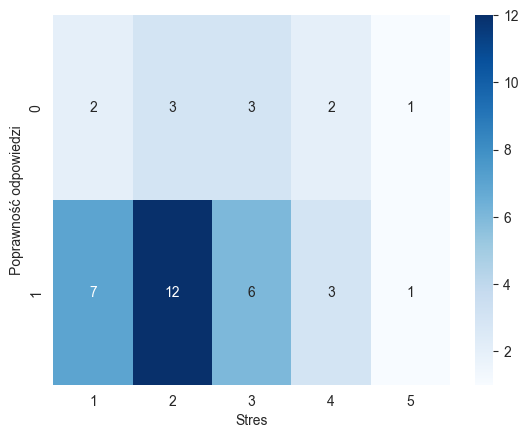

-------------------------------------
3a
Stres    1  2  3  4  5
3a_corr               
0        4  6  3  3  2
1        5  9  6  2  0
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.546576879910213
P-value: 0.4708316586727075
Brak podstaw do odrzucenia H0.


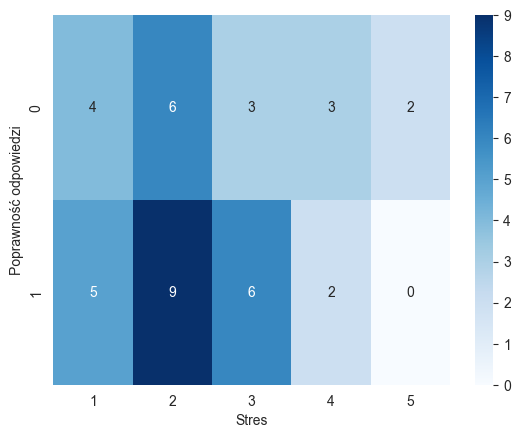

-------------------------------------
3b
Stres    1  2  3  4  5
3b_corr               
0        5  8  4  3  2
1        4  7  5  2  0
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.109988776655443
P-value: 0.7155374995231278
Brak podstaw do odrzucenia H0.


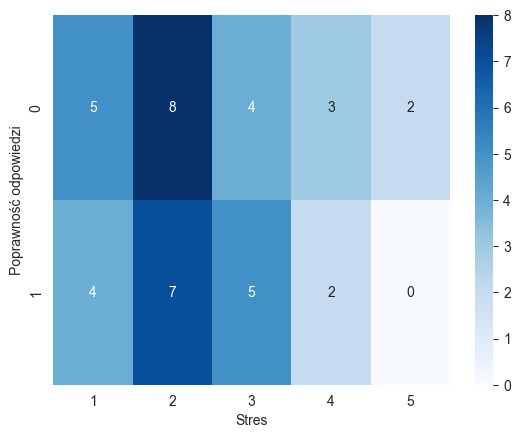

##############################################################
Zmęcz
-------------------------------------
1a
Zmęcz    1   2  3  4  5
1a_corr                
0        0   1  2  1  1
1        6  11  8  8  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.768253968253968
P-value: 0.5973249724735088
Brak podstaw do odrzucenia H0.


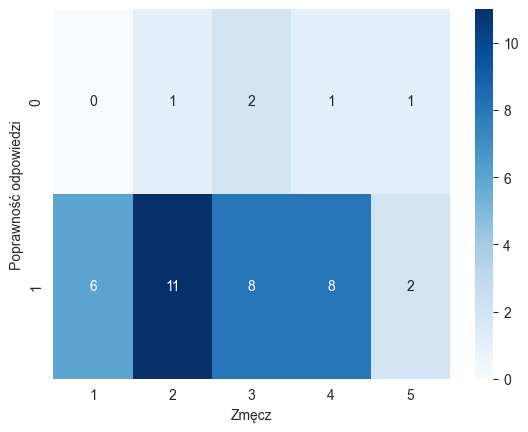

-------------------------------------
1b
Zmęcz    1   2  3  4  5
1b_corr                
0        1   0  1  1  0
1        5  12  9  8  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.2022022022022023
P-value: 0.6986261188231611
Brak podstaw do odrzucenia H0.


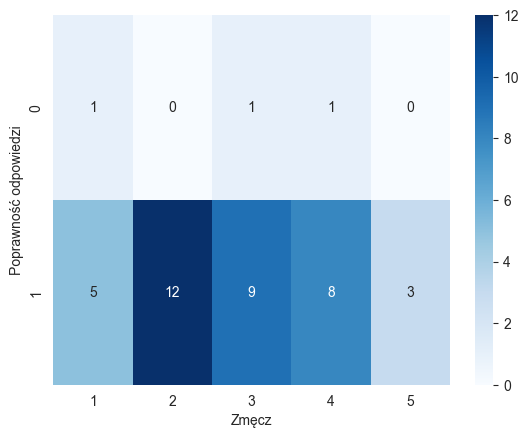

-------------------------------------
2a
Zmęcz    1  2  3  4  5
2a_corr               
0        2  3  3  3  1
1        4  9  7  6  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.23809523809523803
P-value: 0.99345189725498
Brak podstaw do odrzucenia H0.


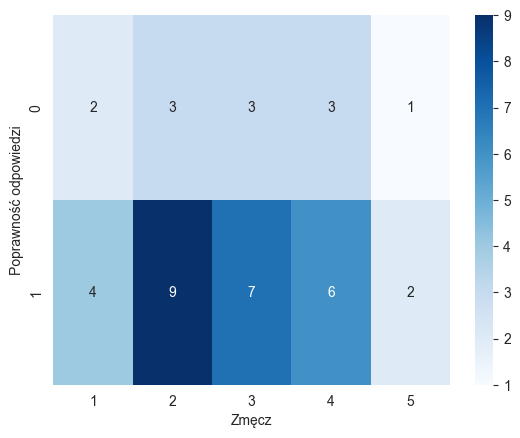

-------------------------------------
2b
Zmęcz    1   2  3  4  5
2b_corr                
0        3   1  3  4  0
1        3  11  7  5  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 6.199930337861372
P-value: 0.18470659411783638
Brak podstaw do odrzucenia H0.


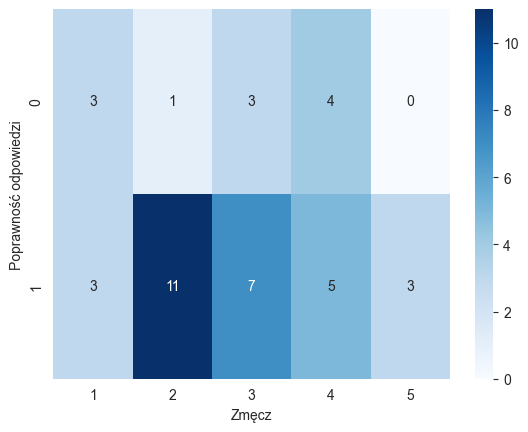

-------------------------------------
3a
Zmęcz    1  2  3  4  5
3a_corr               
0        4  4  4  4  2
1        2  8  6  5  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.469135802469135
P-value: 0.6501709019066686
Brak podstaw do odrzucenia H0.


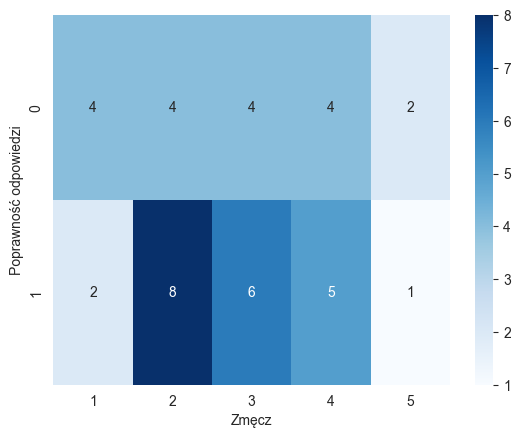

-------------------------------------
3b
Zmęcz    1  2  3  4  5
3b_corr               
0        3  8  4  4  3
1        3  4  6  5  0
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.489337822671157
P-value: 0.34381361105128616
Brak podstaw do odrzucenia H0.


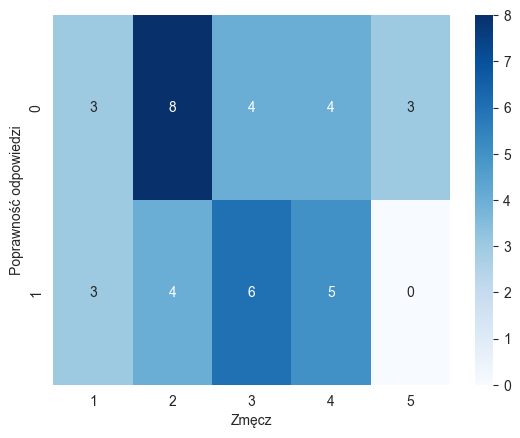

##############################################################
Czyt_map
-------------------------------------
1a
Czyt_map  3   4   5
1a_corr            
0         0   5   0
1         5  20  10
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.4285714285714284
P-value: 0.1800923121479524
Brak podstaw do odrzucenia H0.


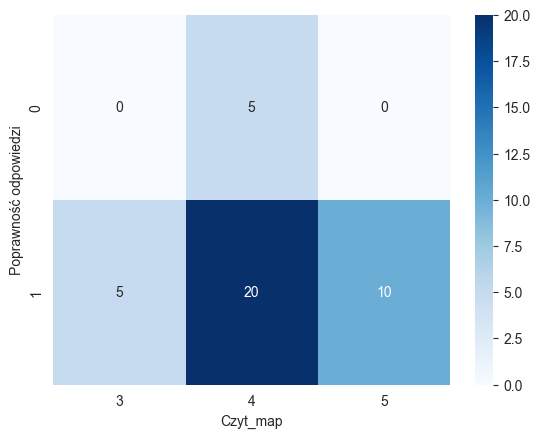

-------------------------------------
1b
Czyt_map  3   4  5
1b_corr           
0         0   2  1
1         5  23  9
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.5045045045045046
P-value: 0.7770487010596451
Brak podstaw do odrzucenia H0.


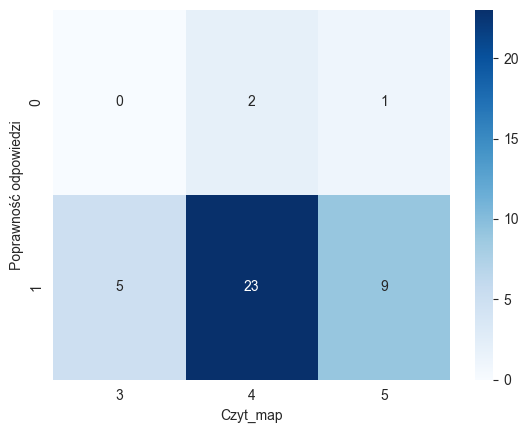

-------------------------------------
2a
Czyt_map  3   4  5
2a_corr           
0         3   6  3
1         2  19  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.5714285714285716
P-value: 0.2764530466295643
Brak podstaw do odrzucenia H0.


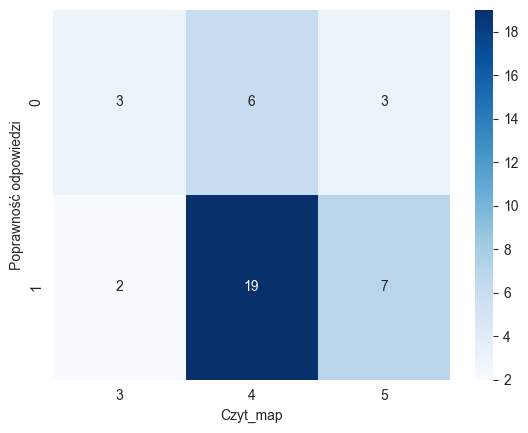

-------------------------------------
2b
Czyt_map  3   4  5
2b_corr           
0         1   6  4
1         4  19  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.078369905956113
P-value: 0.5832234132145395
Brak podstaw do odrzucenia H0.


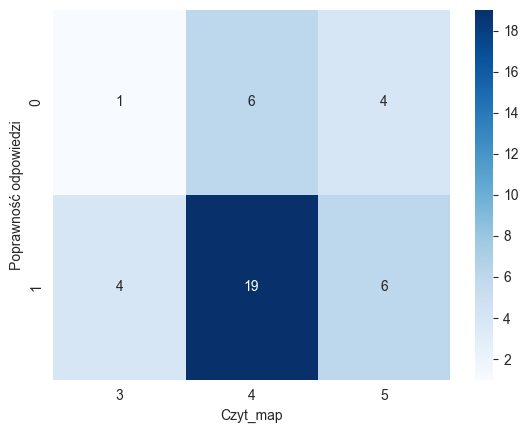

-------------------------------------
3a
Czyt_map  3   4  5
3a_corr           
0         2  11  5
1         3  14  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.1616161616161616
P-value: 0.9223706950973188
Brak podstaw do odrzucenia H0.


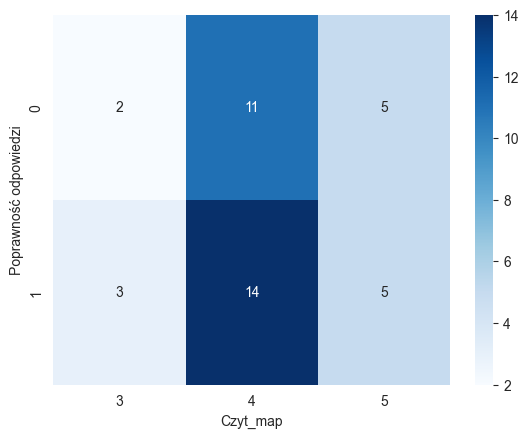

-------------------------------------
3b
Czyt_map  3   4  5
3b_corr           
0         4  14  4
1         1  11  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.1818181818181817
P-value: 0.33591098123916246
Brak podstaw do odrzucenia H0.


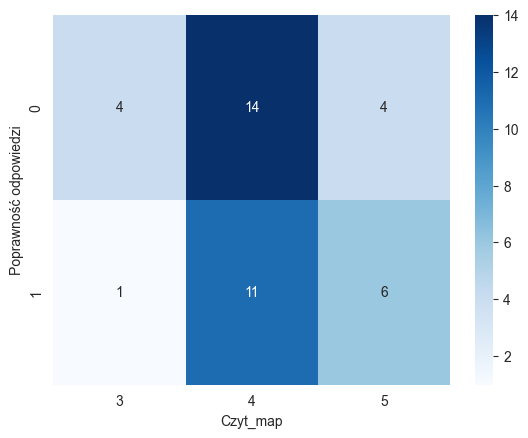

##############################################################
Podziel_uwg
-------------------------------------
1a
Podziel_uwg  1  2   3  4  5
1a_corr                    
0            0  1   2  0  2
1            2  6  12  9  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.7755102040816326
P-value: 0.5960674391667908
Brak podstaw do odrzucenia H0.


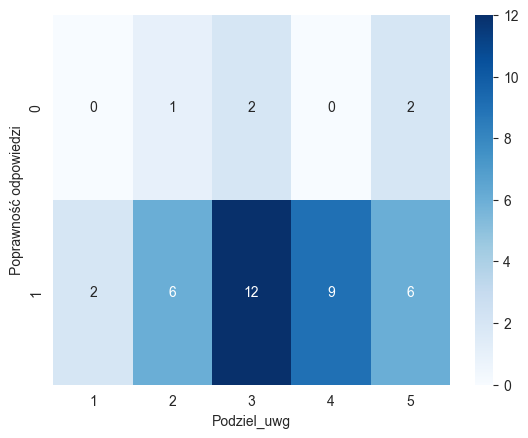

-------------------------------------
1b
Podziel_uwg  1  2   3  4  5
1b_corr                    
0            0  0   2  0  1
1            2  7  12  9  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.6769626769626775
P-value: 0.6132518246610756
Brak podstaw do odrzucenia H0.


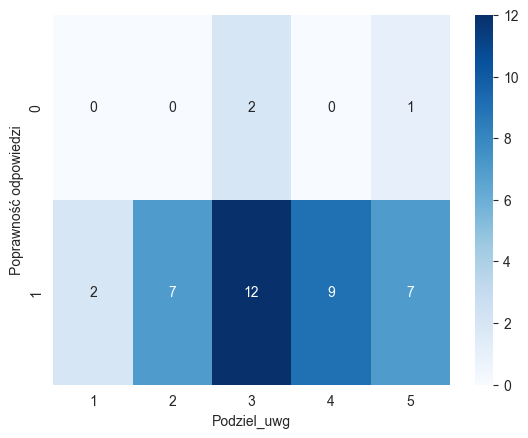

-------------------------------------
2a
Podziel_uwg  1  2   3  4  5
2a_corr                    
0            1  2   4  4  1
1            1  5  10  5  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.4622071050642473
P-value: 0.6514157401508517
Brak podstaw do odrzucenia H0.


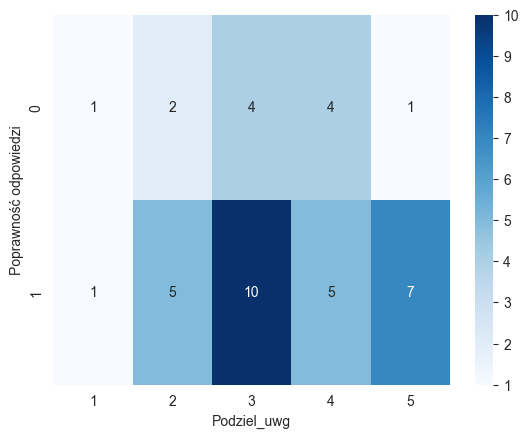

-------------------------------------
2b
Podziel_uwg  1  2   3  4  5
2b_corr                    
0            0  1   4  3  3
1            2  6  10  6  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.9346171070309
P-value: 0.7477832158617013
Brak podstaw do odrzucenia H0.


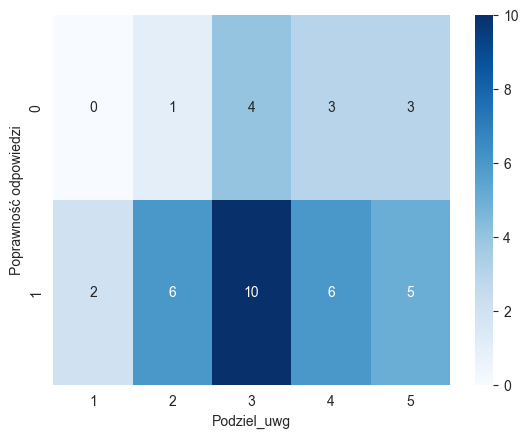

-------------------------------------
3a
Podziel_uwg  1  2   3  4  5
3a_corr                    
0            0  3  10  4  1
1            2  4   4  5  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 9.01555234888568
P-value: 0.06071191961919413
Brak podstaw do odrzucenia H0.


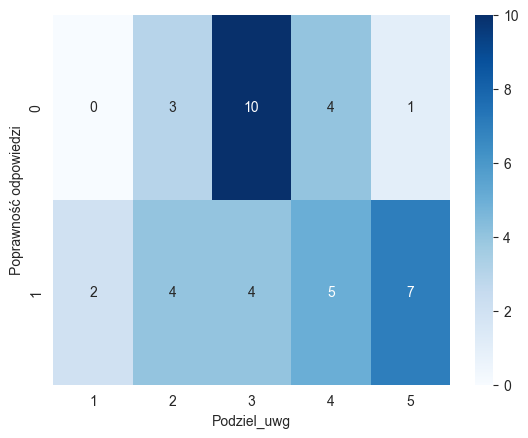

-------------------------------------
3b
Podziel_uwg  1  2  3  4  5
3b_corr                   
0            2  6  6  5  3
1            0  1  8  4  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 6.129549462882796
P-value: 0.18968008168157874
Brak podstaw do odrzucenia H0.


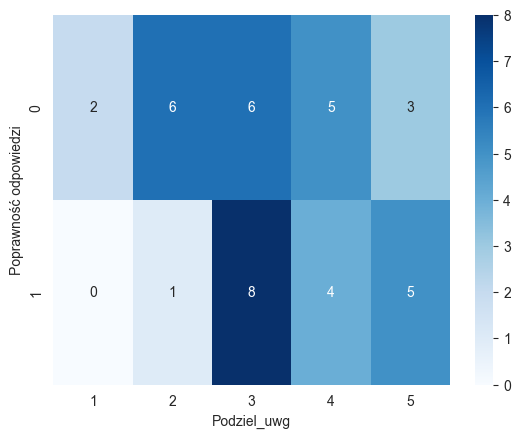

##############################################################
Analit_myśl
-------------------------------------
1a
Analit_myśl  2   3   4  5
1a_corr                  
0            0   1   4  0
1            1  10  15  9
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.8161312371838685
P-value: 0.42085130801734616
Brak podstaw do odrzucenia H0.


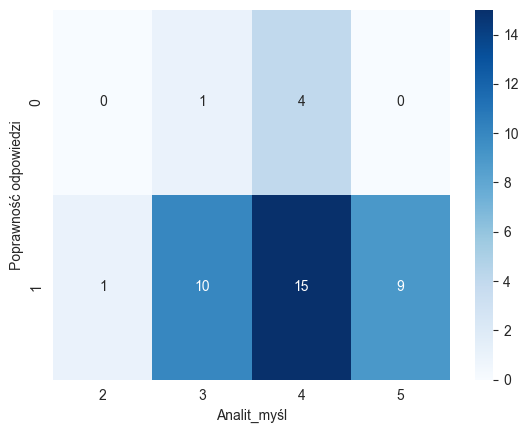

-------------------------------------
1b
Analit_myśl  2   3   4  5
1b_corr                  
0            0   1   2  0
1            1  10  17  9
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.1017716280874175
P-value: 0.7766464228378854
Brak podstaw do odrzucenia H0.


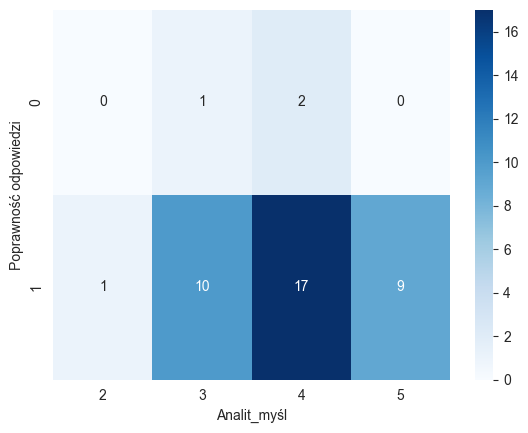

-------------------------------------
2a
Analit_myśl  2  3   4  5
2a_corr                 
0            1  3   6  2
1            0  8  13  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.654110022531075
P-value: 0.4480822281471135
Brak podstaw do odrzucenia H0.


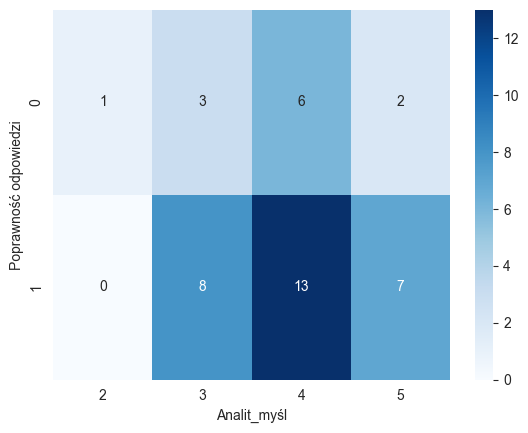

-------------------------------------
2b
Analit_myśl  2  3   4  5
2b_corr                 
0            0  2   5  4
1            1  9  14  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.16779242682559
P-value: 0.5383200876408758
Brak podstaw do odrzucenia H0.


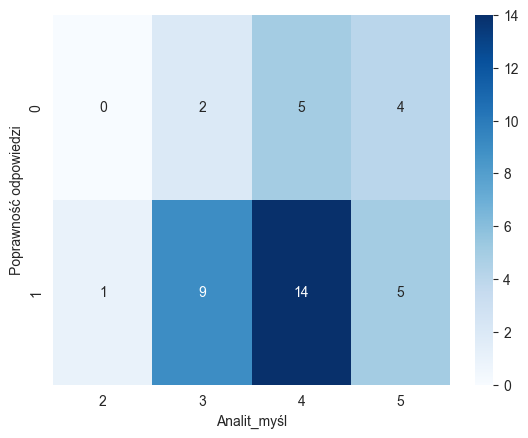

-------------------------------------
3a
Analit_myśl  2  3   4  5
3a_corr                 
0            1  5  10  2
1            0  6   9  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.5568873208426632
P-value: 0.31345862977545663
Brak podstaw do odrzucenia H0.


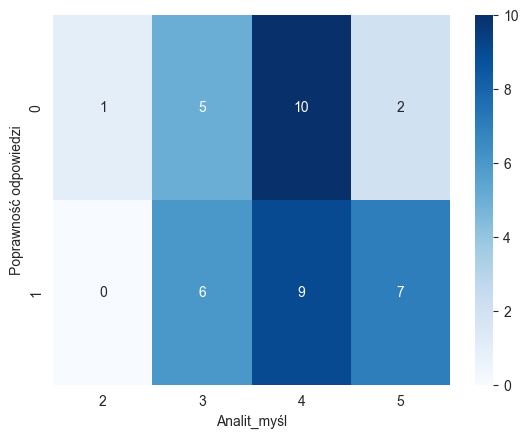

-------------------------------------
3b
Analit_myśl  2  3   4  5
3b_corr                 
0            1  6  11  4
1            0  5   8  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.2885903157035536
P-value: 0.7318441857886728
Brak podstaw do odrzucenia H0.


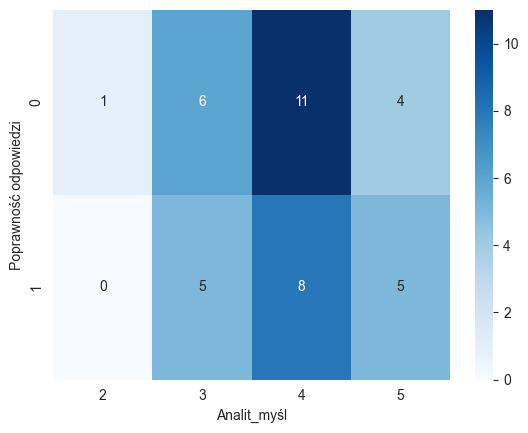

##############################################################
Spostrzeg
-------------------------------------
1a
Spostrzeg  2  3   4  5
1a_corr               
0          0  3   1  1
1          4  8  16  7
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.446906035141329
P-value: 0.3277137972705378
Brak podstaw do odrzucenia H0.


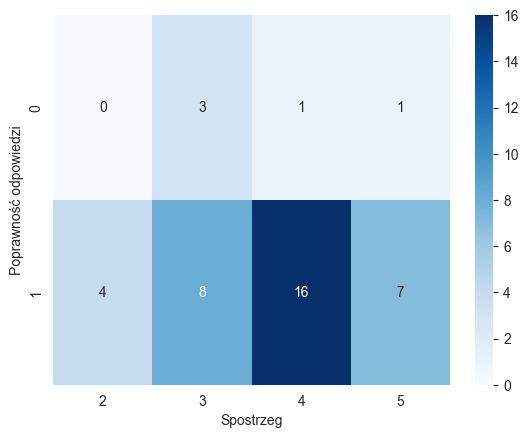

-------------------------------------
1b
Spostrzeg  2   3   4  5
1b_corr                
0          0   1   0  2
1          4  10  17  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 5.274365274365274
P-value: 0.1527744651823055
Brak podstaw do odrzucenia H0.


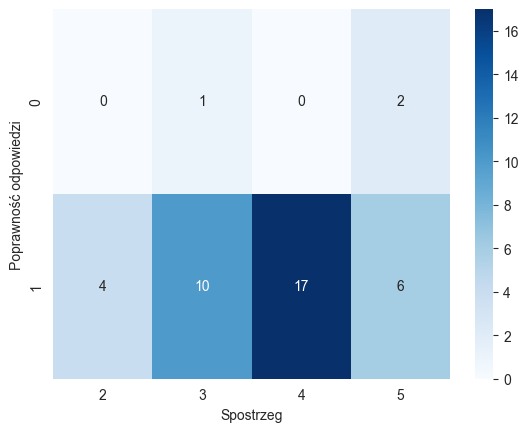

-------------------------------------
2a
Spostrzeg  2  3   4  5
2a_corr               
0          1  3   4  4
1          3  8  13  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.949325184619302
P-value: 0.5829907823775147
Brak podstaw do odrzucenia H0.


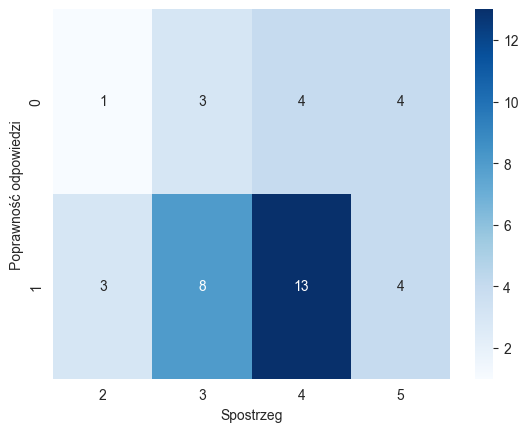

-------------------------------------
2b
Spostrzeg  2  3   4  5
2b_corr               
0          1  2   3  5
1          3  9  14  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 6.23472415469465
P-value: 0.10073238378448716
Brak podstaw do odrzucenia H0.


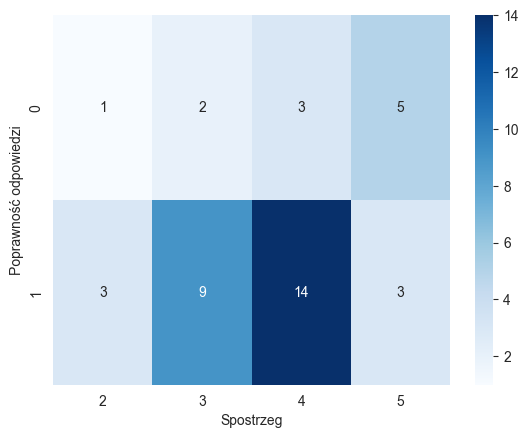

-------------------------------------
3a
Spostrzeg  2  3   4  5
3a_corr               
0          1  5   6  6
1          3  6  11  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.203532652730514
P-value: 0.2403084376213457
Brak podstaw do odrzucenia H0.


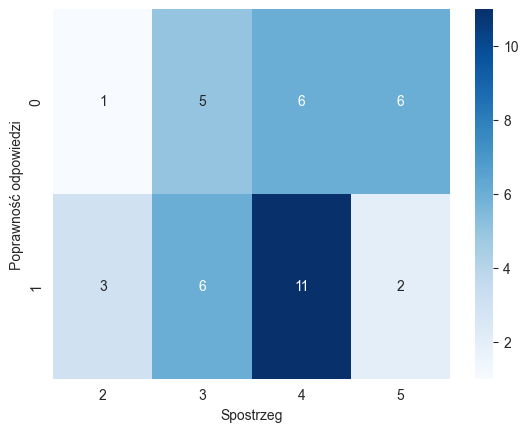

-------------------------------------
3b
Spostrzeg  2  3  4  5
3b_corr              
0          2  7  9  4
1          2  4  8  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.4818235834278616
P-value: 0.9228661553302318
Brak podstaw do odrzucenia H0.


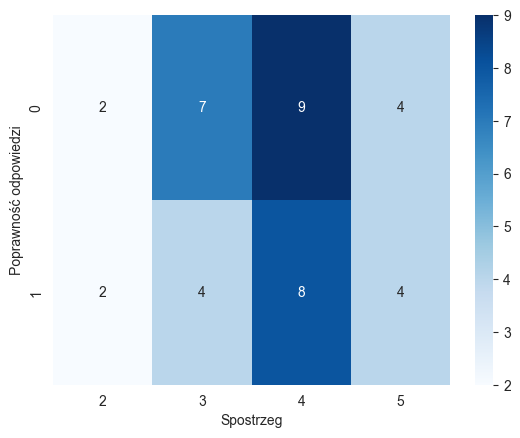

##############################################################
Czyt_ze_zroz
-------------------------------------
1a
Czyt_ze_zroz  1  2  3   4  5
1a_corr                     
0             0  0  2   3  0
1             2  7  4  14  8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 5.2212885154061635
P-value: 0.26533607829047023
Brak podstaw do odrzucenia H0.


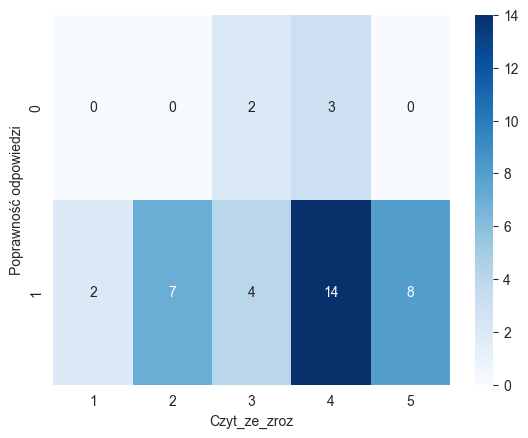

-------------------------------------
1b
Czyt_ze_zroz  1  2  3   4  5
1b_corr                     
0             0  1  0   2  0
1             2  6  6  15  8
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.2075857369975016
P-value: 0.6976407280443628
Brak podstaw do odrzucenia H0.


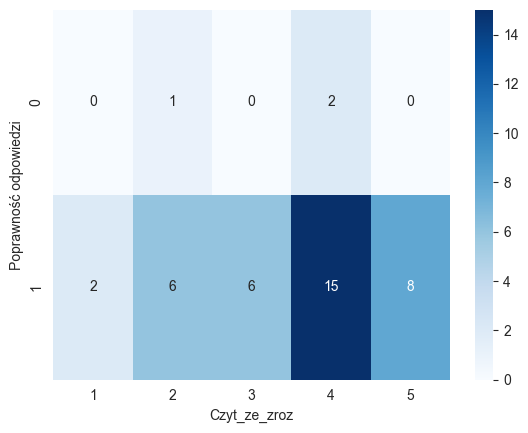

-------------------------------------
2a
Czyt_ze_zroz  1  2  3   4  5
2a_corr                     
0             1  4  1   4  2
1             1  3  5  13  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.7788448712818457
P-value: 0.4367624594409064
Brak podstaw do odrzucenia H0.


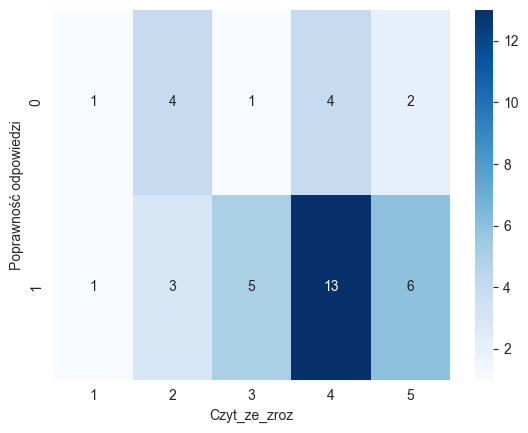

-------------------------------------
2b
Czyt_ze_zroz  1  2  3   4  5
2b_corr                     
0             1  2  2   4  2
1             1  5  4  13  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.7737765952776094
P-value: 0.9419287023684074
Brak podstaw do odrzucenia H0.


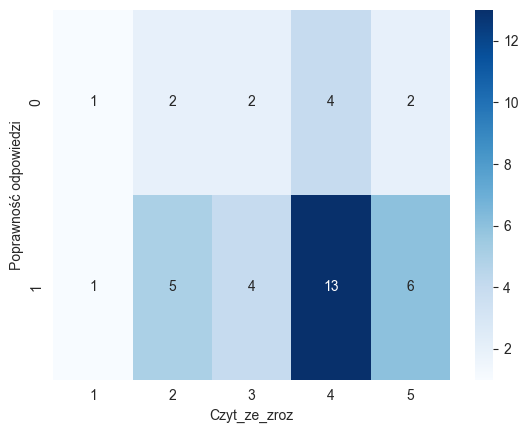

-------------------------------------
3a
Czyt_ze_zroz  1  2  3   4  5
3a_corr                     
0             1  3  4   4  6
1             1  4  2  13  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 7.246696658461365
P-value: 0.12341172694556826
Brak podstaw do odrzucenia H0.


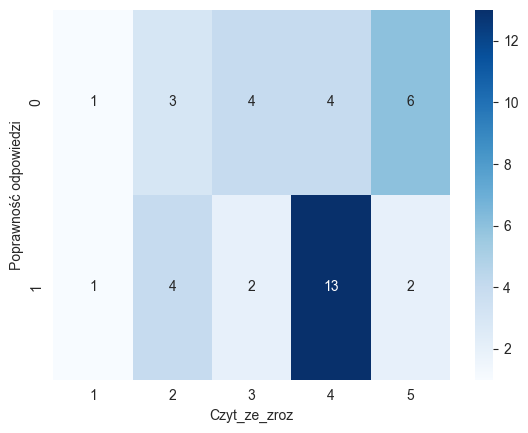

-------------------------------------
3b
Czyt_ze_zroz  1  2  3  4  5
3b_corr                    
0             1  5  3  9  4
1             1  2  3  8  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.9540786011374244
P-value: 0.9166773807204579
Brak podstaw do odrzucenia H0.


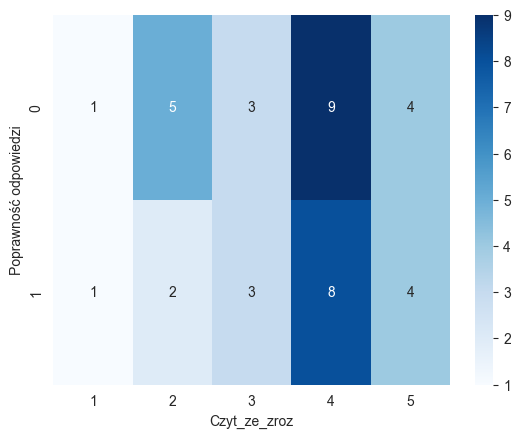

##############################################################
Wzrokowiec
-------------------------------------
1a
Wzrokowiec  2  3   4   5
1a_corr                 
0           0  0   3   2
1           2  9  12  12
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.3836734693877553
P-value: 0.49668103709815625
Brak podstaw do odrzucenia H0.


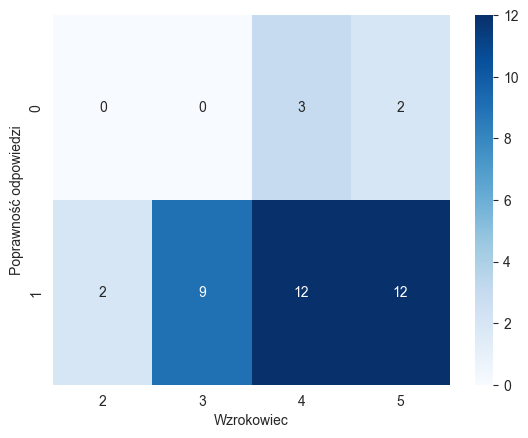

-------------------------------------
1b
Wzrokowiec  2  3   4   5
1b_corr                 
0           0  0   2   1
1           2  9  13  13
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.6302016302016302
P-value: 0.6525613558026033
Brak podstaw do odrzucenia H0.


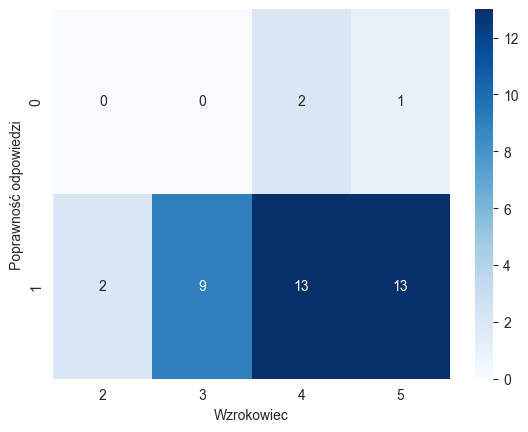

-------------------------------------
2a
Wzrokowiec  2  3   4   5
2a_corr                 
0           1  2   5   4
1           1  7  10  10
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.7331821617535904
P-value: 0.865372790068283
Brak podstaw do odrzucenia H0.


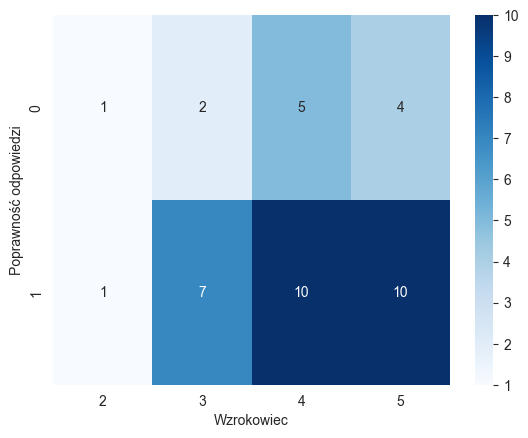

-------------------------------------
2b
Wzrokowiec  2  3   4   5
2b_corr                 
0           0  2   5   4
1           2  7  10  10
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.1484301139473554
P-value: 0.7653975645170833
Brak podstaw do odrzucenia H0.


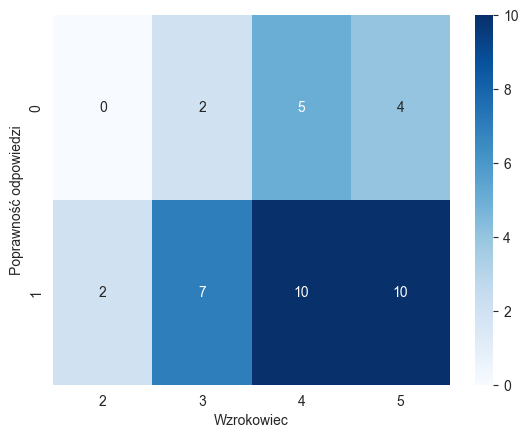

-------------------------------------
3a
Wzrokowiec  2  3  4  5
3a_corr               
0           0  4  6  8
1           2  5  9  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.6230559563892895
P-value: 0.45346186960297163
Brak podstaw do odrzucenia H0.


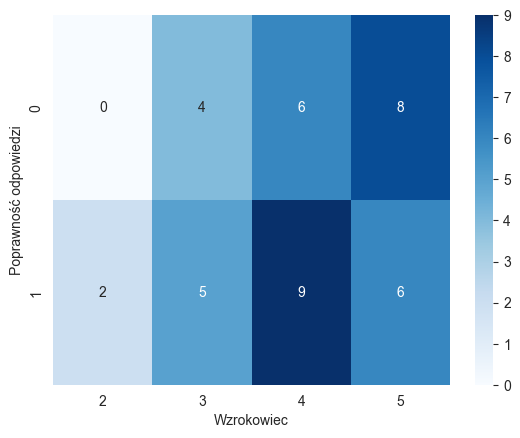

-------------------------------------
3b
Wzrokowiec  2  3  4  5
3b_corr               
0           1  5  8  8
1           1  4  7  6
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.06413339746673077
P-value: 0.9957625491971955
Brak podstaw do odrzucenia H0.


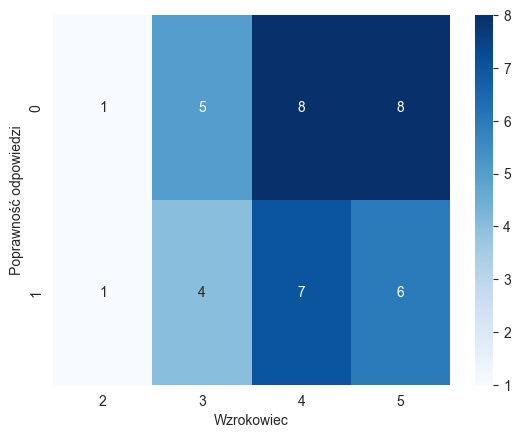

##############################################################
Słuchowiec
-------------------------------------
1a
Słuchowiec  1  2   3  4  5
1a_corr                   
0           0  2   1  1  1
1           4  6  14  6  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.296598639455782
P-value: 0.6813883952232445
Brak podstaw do odrzucenia H0.


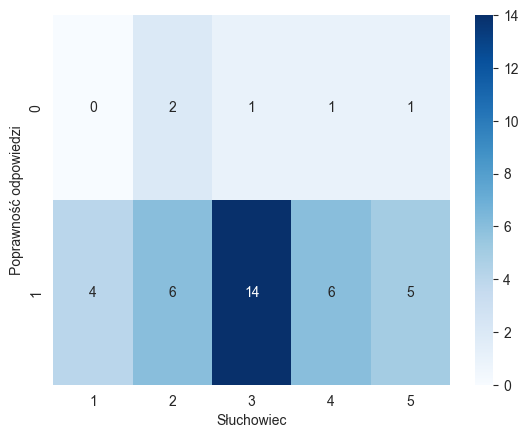

-------------------------------------
1b
Słuchowiec  1  2   3  4  5
1b_corr                   
0           1  0   1  0  1
1           3  8  14  7  5
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.7237237237237233
P-value: 0.44468485078649567
Brak podstaw do odrzucenia H0.


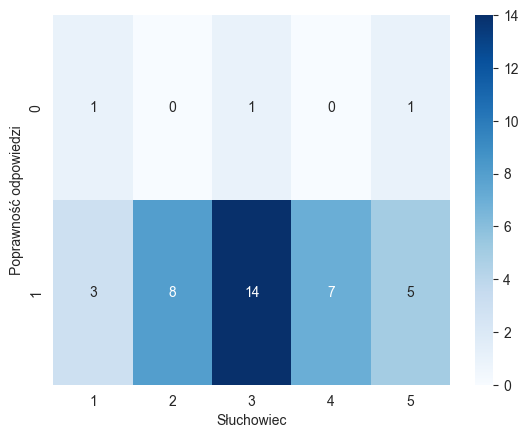

-------------------------------------
2a
Słuchowiec  1  2   3  4  5
2a_corr                   
0           3  1   3  3  2
1           1  7  12  4  4
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 6.320861678004535
P-value: 0.1764333308213397
Brak podstaw do odrzucenia H0.


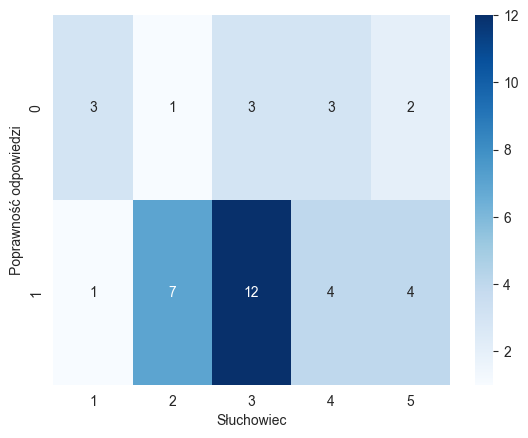

-------------------------------------
2b
Słuchowiec  1  2   3  4  5
2b_corr                   
0           3  1   3  1  3
1           1  7  12  6  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 7.989252127183161
P-value: 0.09197269711776848
Brak podstaw do odrzucenia H0.


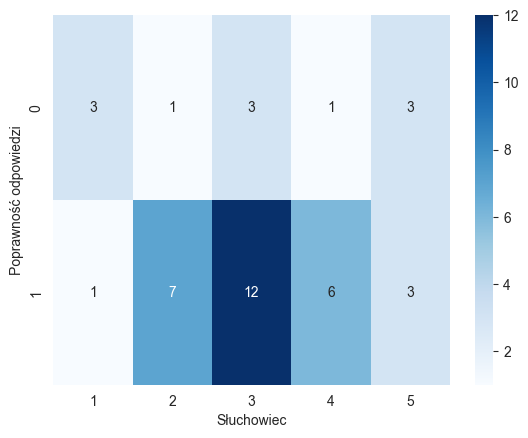

-------------------------------------
3a
Słuchowiec  1  2  3  4  5
3a_corr                  
0           1  5  8  1  3
1           3  3  7  6  3
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 4.785954785954786
P-value: 0.3099731587157868
Brak podstaw do odrzucenia H0.


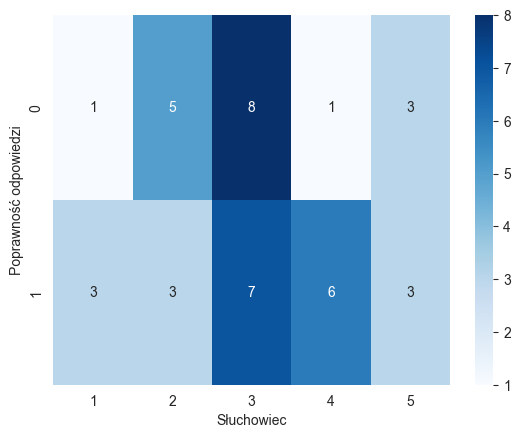

-------------------------------------
3b
Słuchowiec  1  2  3  4  5
3b_corr                  
0           1  6  7  4  4
1           3  2  8  3  2
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.5113035113035114
P-value: 0.4761617035493819
Brak podstaw do odrzucenia H0.


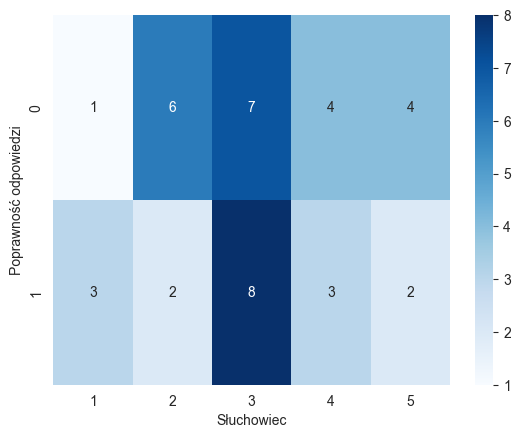

##############################################################
Kinestetyk
-------------------------------------
1a
Kinestetyk  1   2  3  4  5
1a_corr                   
0           1   2  0  2  0
1           8  15  3  8  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.1099906629318392
P-value: 0.8926838535998075
Brak podstaw do odrzucenia H0.


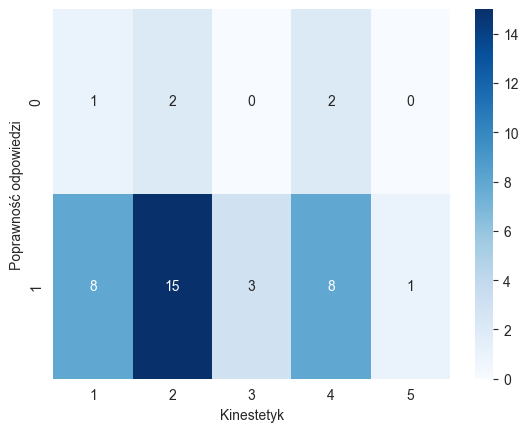

-------------------------------------
1b
Kinestetyk  1   2  3  4  5
1b_corr                   
0           1   1  0  1  0
1           8  16  3  9  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.6477065300594712
P-value: 0.9576177005041085
Brak podstaw do odrzucenia H0.


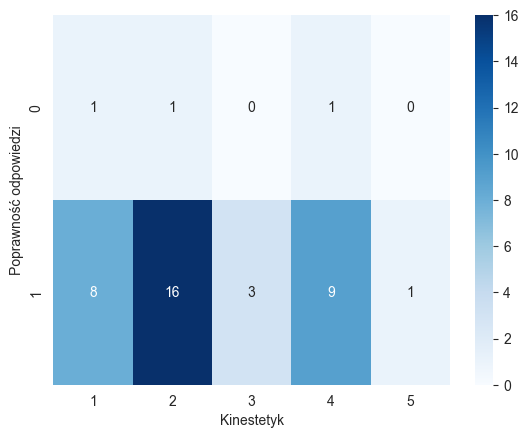

-------------------------------------
2a
Kinestetyk  1   2  3  4  5
2a_corr                   
0           3   4  1  3  1
1           6  13  2  7  0
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.735760971055088
P-value: 0.6029715642980685
Brak podstaw do odrzucenia H0.


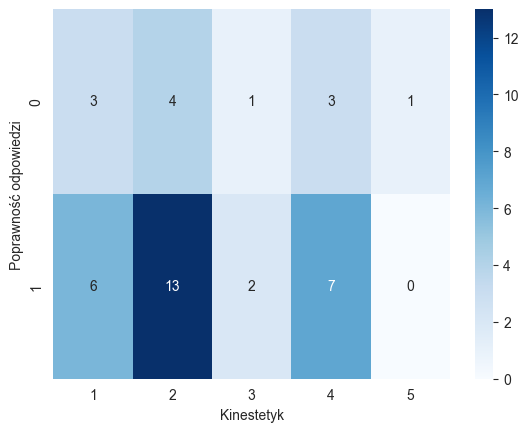

-------------------------------------
2b
Kinestetyk  1   2  3  4  5
2b_corr                   
0           2   5  0  3  1
1           7  12  3  7  0
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 3.962546356055484
P-value: 0.41109837914909375
Brak podstaw do odrzucenia H0.


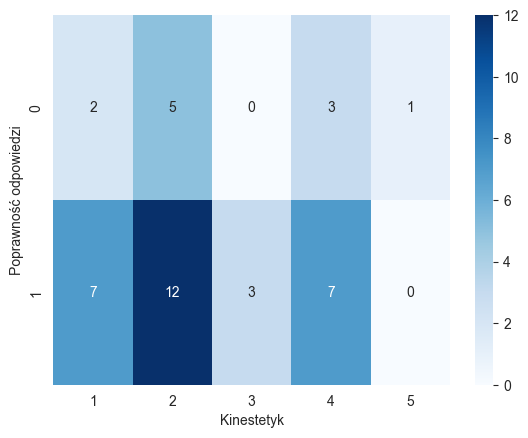

-------------------------------------
3a
Kinestetyk  1   2  3  4  5
3a_corr                   
0           3   7  2  6  0
1           6  10  1  4  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.891661715191127
P-value: 0.576116159202028
Brak podstaw do odrzucenia H0.


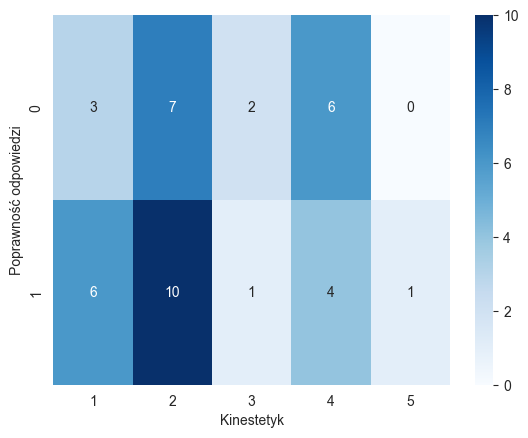

-------------------------------------
3b
Kinestetyk  1   2  3  4  5
3b_corr                   
0           7   7  1  7  0
1           2  10  2  3  1
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 5.899518056380801
P-value: 0.20677904802096048
Brak podstaw do odrzucenia H0.


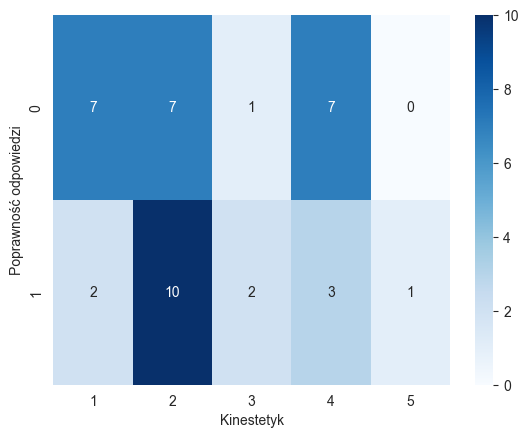

##############################################################
MAT
-------------------------------------
1a
MAT      NO_VAL  VAL
1a_corr             
0             4    1
1            14   21
Fisher test conducted...
Fisher test statistic value: 6.0
P-value: 0.15535069482437908
Brak podstaw do odrzucenia H0.


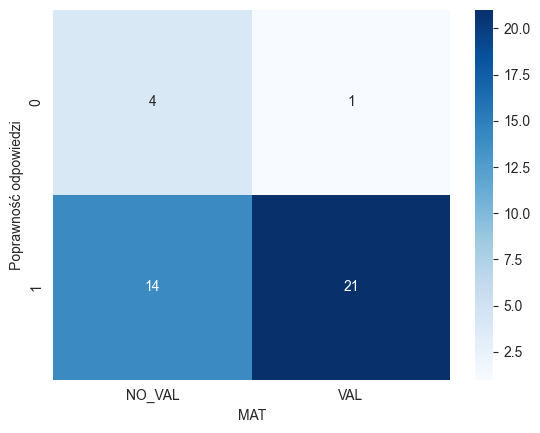

-------------------------------------
1b
MAT      NO_VAL  VAL
1b_corr             
0             2    1
1            16   21
Fisher test conducted...
Fisher test statistic value: 2.625
P-value: 0.5791497975708503
Brak podstaw do odrzucenia H0.


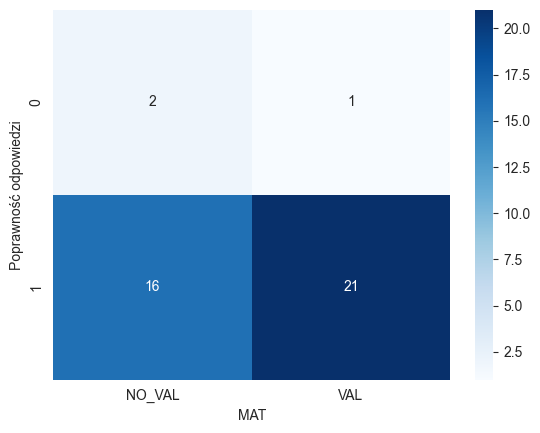

-------------------------------------
2a
MAT      NO_VAL  VAL
2a_corr             
0             4    8
1            14   14
Fisher test conducted...
Fisher test statistic value: 0.5
P-value: 0.490529555824328
Brak podstaw do odrzucenia H0.


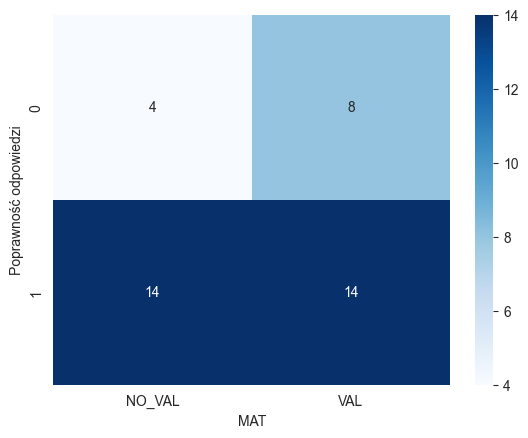

-------------------------------------
2b
MAT      NO_VAL  VAL
2b_corr             
0             3    8
1            15   14
Fisher test conducted...
Fisher test statistic value: 0.35
P-value: 0.28626517336194757
Brak podstaw do odrzucenia H0.


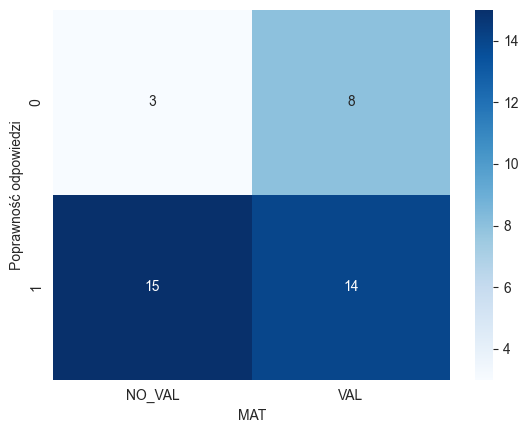

-------------------------------------
3a
MAT      NO_VAL  VAL
3a_corr             
0             9    9
1             9   13
Chi2 test conducted...
Chi-squared test statistic value: 0.3305785123966944
P-value: 0.5653186374272072
Brak podstaw do odrzucenia H0.


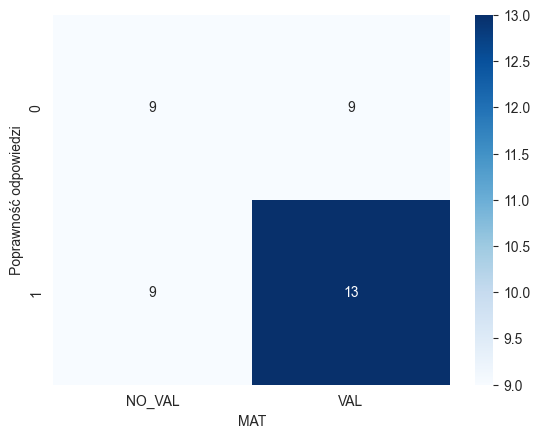

-------------------------------------
3b
MAT      NO_VAL  VAL
3b_corr             
0            11   11
1             7   11
Chi2 test conducted...
Chi-squared test statistic value: 0.4938271604938269
P-value: 0.4822250447560401
Brak podstaw do odrzucenia H0.


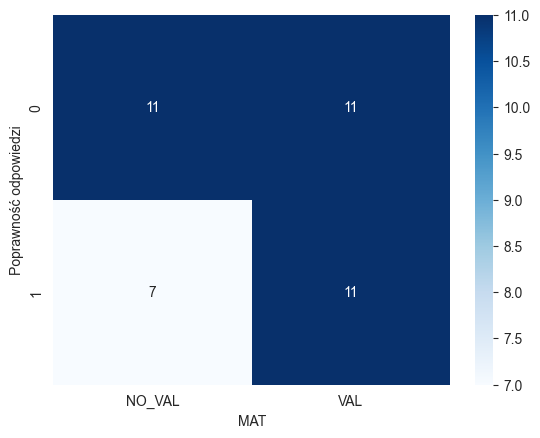

##############################################################
POL
-------------------------------------
1a
POL      NO_VAL  VAL
1a_corr             
0             4    1
1            27    8
Fisher test conducted...
Fisher test statistic value: 1.1851851851851851
P-value: 1.0
Brak podstaw do odrzucenia H0.


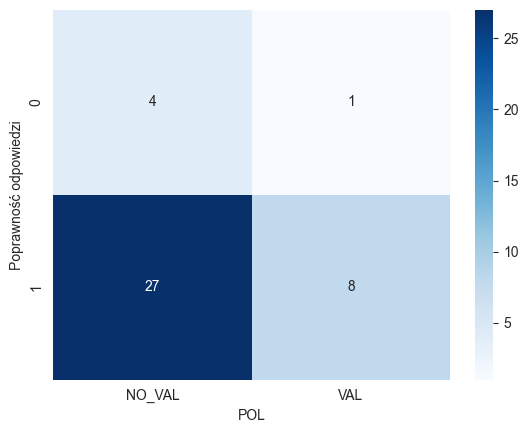

-------------------------------------
1b
POL      NO_VAL  VAL
1b_corr             
0             3    0
1            28    9
Fisher test conducted...
Fisher test statistic value: inf
P-value: 1.0
Brak podstaw do odrzucenia H0.


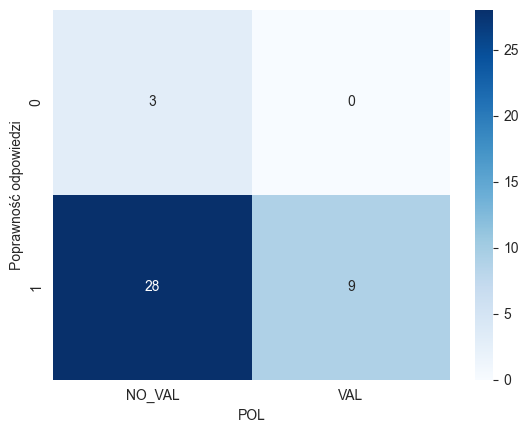

-------------------------------------
2a
POL      NO_VAL  VAL
2a_corr             
0             8    4
1            23    5
Fisher test conducted...
Fisher test statistic value: 0.43478260869565216
P-value: 0.41109530583214793
Brak podstaw do odrzucenia H0.


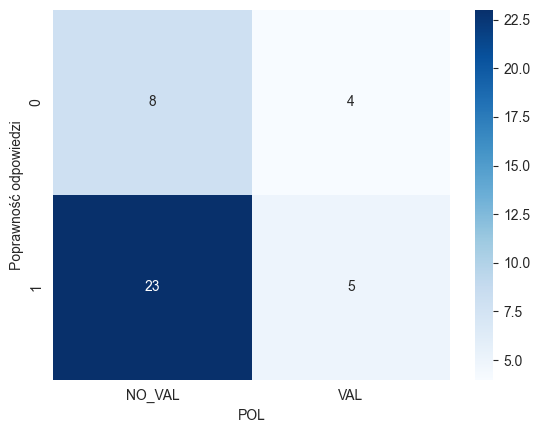

-------------------------------------
2b
POL      NO_VAL  VAL
2b_corr             
0             8    3
1            23    6
Fisher test conducted...
Fisher test statistic value: 0.6956521739130435
P-value: 0.6860618358296376
Brak podstaw do odrzucenia H0.


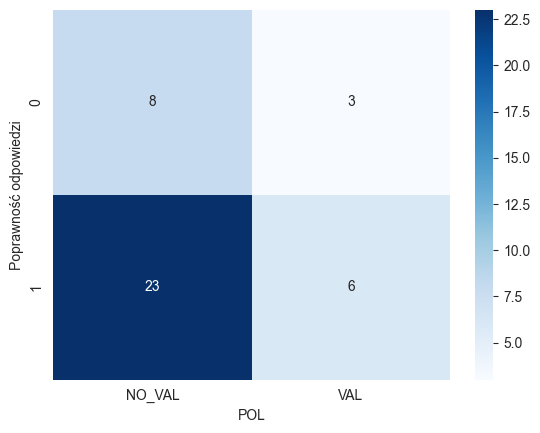

-------------------------------------
3a
POL      NO_VAL  VAL
3a_corr             
0            14    4
1            17    5
Fisher test conducted...
Fisher test statistic value: 1.0294117647058822
P-value: 1.0
Brak podstaw do odrzucenia H0.


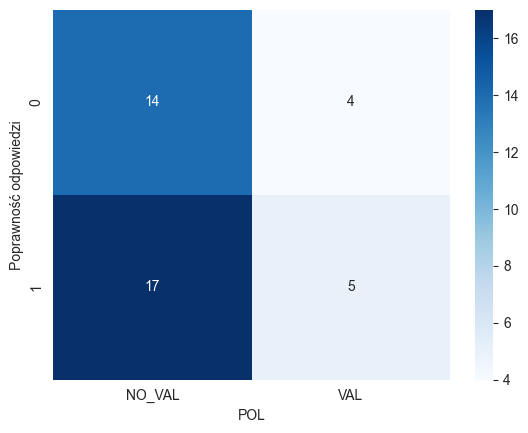

-------------------------------------
3b
POL      NO_VAL  VAL
3b_corr             
0            18    4
1            13    5
Fisher test conducted...
Fisher test statistic value: 1.7307692307692308
P-value: 0.7053014553014554
Brak podstaw do odrzucenia H0.


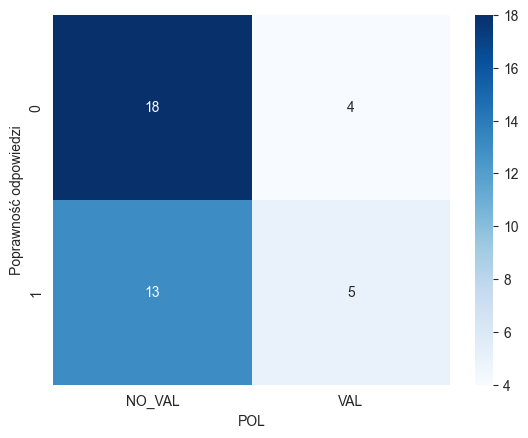

##############################################################
HIST
-------------------------------------
1a
HIST     NO_VAL  VAL
1a_corr             
0             5    0
1            31    4
Fisher test conducted...
Fisher test statistic value: inf
P-value: 1.0
Brak podstaw do odrzucenia H0.


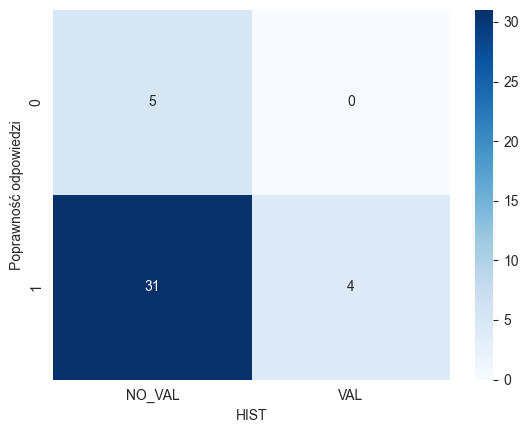

-------------------------------------
1b
HIST     NO_VAL  VAL
1b_corr             
0             3    0
1            33    4
Fisher test conducted...
Fisher test statistic value: inf
P-value: 1.0
Brak podstaw do odrzucenia H0.


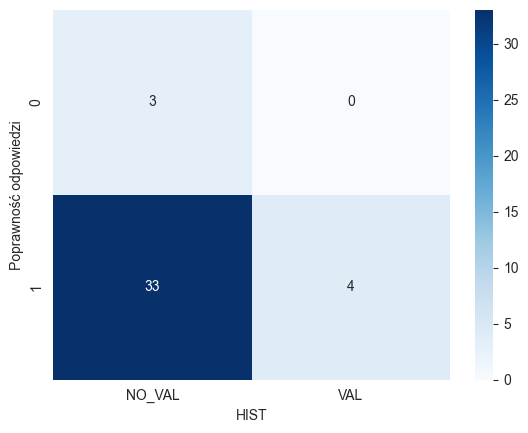

-------------------------------------
2a
HIST     NO_VAL  VAL
2a_corr             
0            11    1
1            25    3
Fisher test conducted...
Fisher test statistic value: 1.32
P-value: 1.0
Brak podstaw do odrzucenia H0.


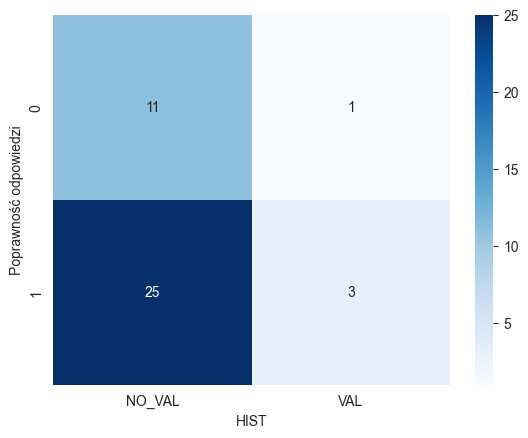

-------------------------------------
2b
HIST     NO_VAL  VAL
2b_corr             
0            10    1
1            26    3
Fisher test conducted...
Fisher test statistic value: 1.1538461538461537
P-value: 1.0
Brak podstaw do odrzucenia H0.


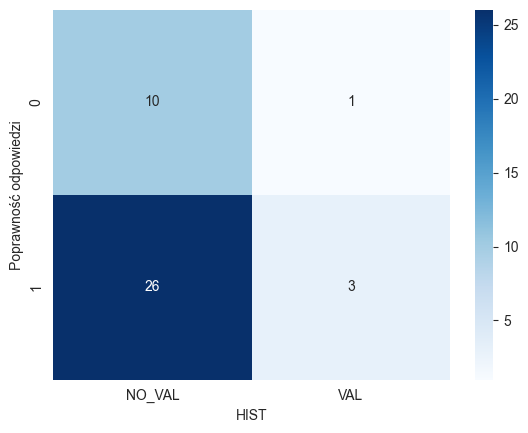

-------------------------------------
3a
HIST     NO_VAL  VAL
3a_corr             
0            18    0
1            18    4
Fisher test conducted...
Fisher test statistic value: inf
P-value: 0.1135244556297188
Brak podstaw do odrzucenia H0.


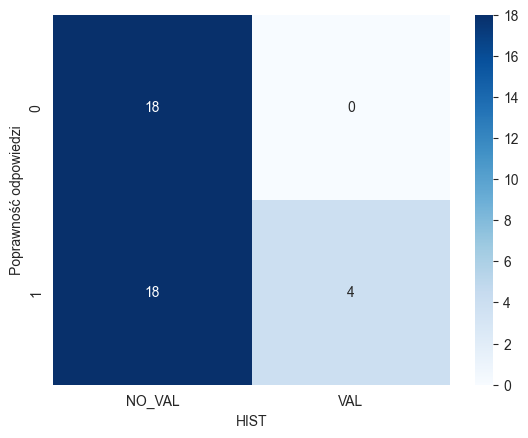

-------------------------------------
3b
HIST     NO_VAL  VAL
3b_corr             
0            20    2
1            16    2
Fisher test conducted...
Fisher test statistic value: 1.25
P-value: 1.0
Brak podstaw do odrzucenia H0.


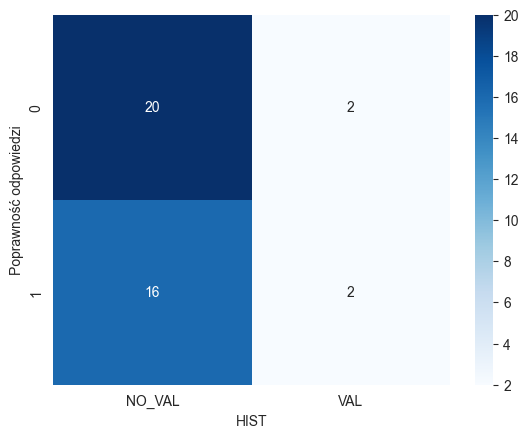

##############################################################
Typ_uczenia
-------------------------------------
1a
Typ_uczenia  Brak dominującego  Kinestetyk  Słuchowiec  Wzrokowiec
1a_corr                                                           
0                            1           0           1           3
1                            9           2           5          19
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.464069264069264
P-value: 0.9267112768970087
Brak podstaw do odrzucenia H0.


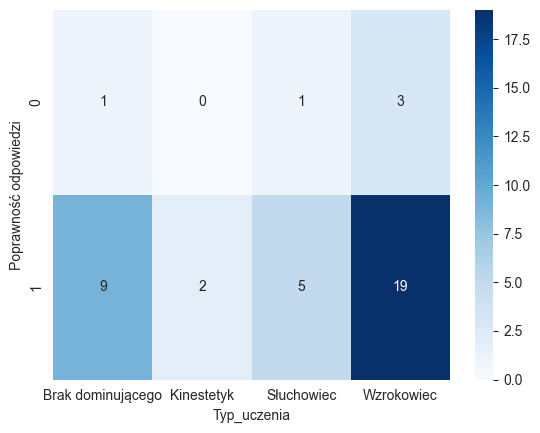

-------------------------------------
1b
Typ_uczenia  Brak dominującego  Kinestetyk  Słuchowiec  Wzrokowiec
1b_corr                                                           
0                            0           0           1           2
1                           10           2           5          20
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 1.7799617799617802
P-value: 0.6193051549007986
Brak podstaw do odrzucenia H0.


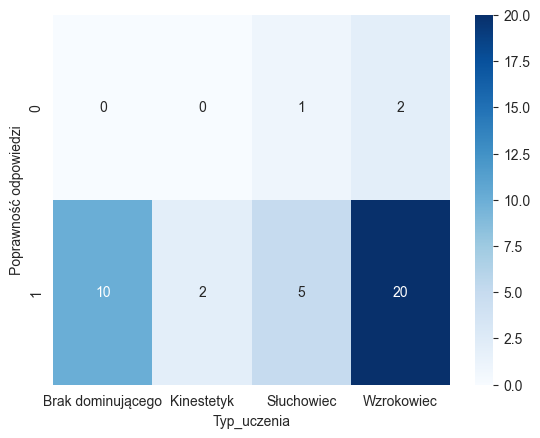

-------------------------------------
2a
Typ_uczenia  Brak dominującego  Kinestetyk  Słuchowiec  Wzrokowiec
2a_corr                                                           
0                            2           1           3           6
1                            8           1           3          16
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 2.0779220779220777
P-value: 0.5563921741582865
Brak podstaw do odrzucenia H0.


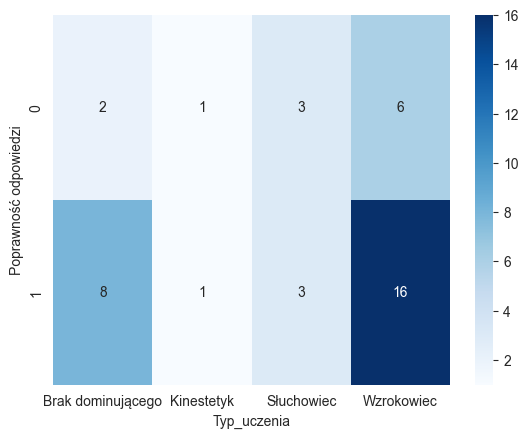

-------------------------------------
2b
Typ_uczenia  Brak dominującego  Kinestetyk  Słuchowiec  Wzrokowiec
2b_corr                                                           
0                            1           1           4           5
1                            9           1           2          17
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 6.911750736202146
P-value: 0.0747644067196321
Brak podstaw do odrzucenia H0.


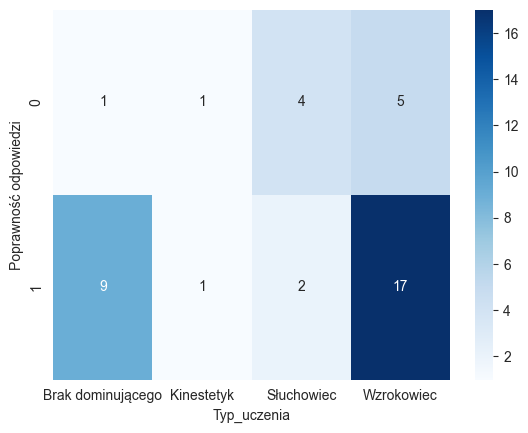

-------------------------------------
3a
Typ_uczenia  Brak dominującego  Kinestetyk  Słuchowiec  Wzrokowiec
3a_corr                                                           
0                            4           1           2          11
1                            6           1           4          11
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.6734006734006734
P-value: 0.8794418194194192
Brak podstaw do odrzucenia H0.


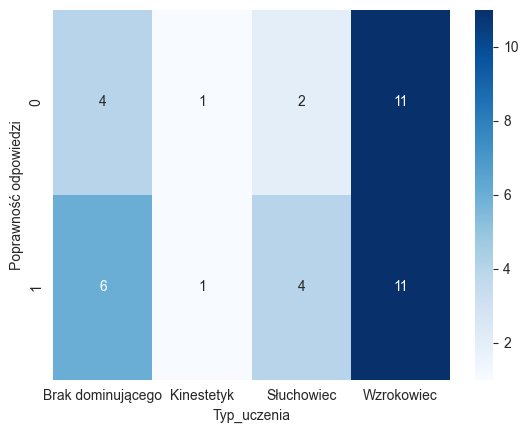

-------------------------------------
3b
Typ_uczenia  Brak dominującego  Kinestetyk  Słuchowiec  Wzrokowiec
3b_corr                                                           
0                            6           1           4          11
1                            4           1           2          11
Chi2 test with Yate's correction conducted...
Chi-squared test statistic value: 0.6734006734006734
P-value: 0.8794418194194192
Brak podstaw do odrzucenia H0.


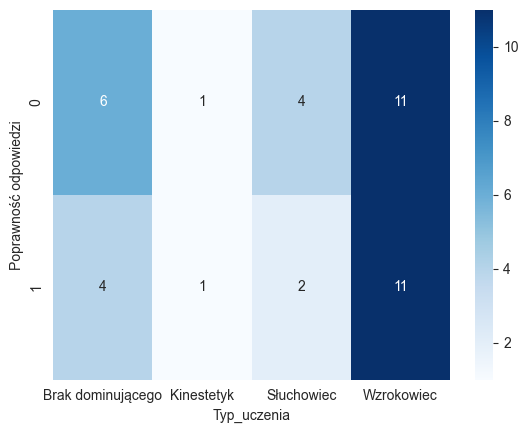

In [40]:
results = []
for col in columns:
    results.append('\n')
    print('##############################################################')
    print(col)
    results.append(col)
    for pref in prefix:
        print('-------------------------------------')
        print(pref)
        if col in ['Płeć', 'Wady_wzroku', 'MAT', 'POL', 'HIST']:
            p_val = chi2_or_fisher_test(df_merge, f'{pref}_corr', col, ALPHA)
        else:
            p_val = chi2_or_chi2_yate_test(df_merge, f'{pref}_corr', col, ALPHA)
        plot_heatmap(df_merge, f'{pref}_corr', col, 'Poprawność odpowiedzi', col, cmap='Blues')
        results.append(p_val)

In [41]:
import csv
with open('results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    row = []
    for item in results:
        if item != '\n':
            row.append(item)
        else:
            writer.writerow(row)
            row = []
    if row:  # Sprawdzamy, czy jest coś do zapisania w ostatnim wierszu
        writer.writerow(row)

In [42]:
posthocNemenyi_test(df_merge, '1a_corr', 'Stres', ALPHA)
posthocNemenyi_test(df_merge, '3a_corr', 'Samopocz', ALPHA)
posthocNemenyi_test(df_merge, '3b_corr', 'MAT_podst', ALPHA)

+----+----------+----------+----------+----------+----------+
|    |        2 |        1 |        3 |        4 |        5 |
+====+==========+==========+==========+==========+==========+
|  2 | 1        | 0.00989  | 0.24065  | 0.001075 | 0.040864 |
+----+----------+----------+----------+----------+----------+
|  1 | 0.00989  | 1        | 0.850972 | 0.835433 | 0.885688 |
+----+----------+----------+----------+----------+----------+
|  3 | 0.24065  | 0.850972 | 1        | 0.3088   | 0.531506 |
+----+----------+----------+----------+----------+----------+
|  4 | 0.001075 | 0.835433 | 0.3088   | 1        | 0.9998   |
+----+----------+----------+----------+----------+----------+
|  5 | 0.040864 | 0.885688 | 0.531506 | 0.9998   | 1        |
+----+----------+----------+----------+----------+----------+
+----+----------+----------+----------+----------+
|    |        4 |        3 |        5 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.000727 | 0.026994 | 0

Podsumowanie - poprawność, każda grafika osobno:
Istotne statystycznie:
- Stres: 1a (2 vs pozostałe, poza 3)
- samopoczucie: 3a (4 vs pozostałe)
- Matura podstawowa matematyka: 3b (50-69% vs 90-100%)
